# Import Packages

In [1]:
#from google.colab import drive
from datetime import datetime
from time import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter

from skimage.transform import rescale,resize
from skimage.feature import hog
from skimage.feature import local_binary_pattern as lbp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

#drive.mount('/content/drive',force_remount=True)

In [2]:
# Extract Zip file to local run time (to avoid wasting storage on drive)
# Change the path below as needed - should point to the cleaned data zip file
# !unzip -qq -n /content/drive/MyDrive/Data281Project/cleaned.zip
# !unzip -qq -n /content/drive/MyDrive/0281_Computer_Vision/Project/Data281Project/cleaned.zip

In [10]:
# Set project folder path
project_path = '/mnt/c/Users/River/Desktop/code/281'

# Starter code

Checking if the cleaned data has been loaded correctly

In [3]:
# Use the Kaggle dataset to find the number of image to find subregions
count_base = 'content/cleaned_dataset/'
data_count = {}
img_path = os.listdir(count_base)

for country in img_path:
    num_count = len(os.listdir(count_base+country))
    data_count[str(country)] =num_count
country_name_count = pd.DataFrame(data={'count':data_count.values()},index = data_count.keys())

country_name_count

count
australia_and_new_zealand         7828
eastern_asia                      7828
eastern_europe                    7828
latin_america_and_the_caribbean   7828
northern_america                  7828
northern_europe                   7828
southern_europe                   7828
south_eastern_asia                7828
sub_saharan_africa                7828
western_europe                    7828

In [4]:
# Create mapping from labels to image_path
label_img = {}
for label in country_name_count.index:
    label_img[label] = []
    img_path = os.listdir(f'{count_base}{label}')
    img_path = [f'{count_base}{label}/'+i for i in img_path]
    label_img[label] += img_path

print(label_img.keys())
print(label_img['eastern_asia'][0])

dict_keys(['australia_and_new_zealand', 'eastern_asia', 'eastern_europe', 'latin_america_and_the_caribbean', 'northern_america', 'northern_europe', 'southern_europe', 'south_eastern_asia', 'sub_saharan_africa', 'western_europe'])
content/cleaned_dataset/eastern_asia/0.jpg


## Example images

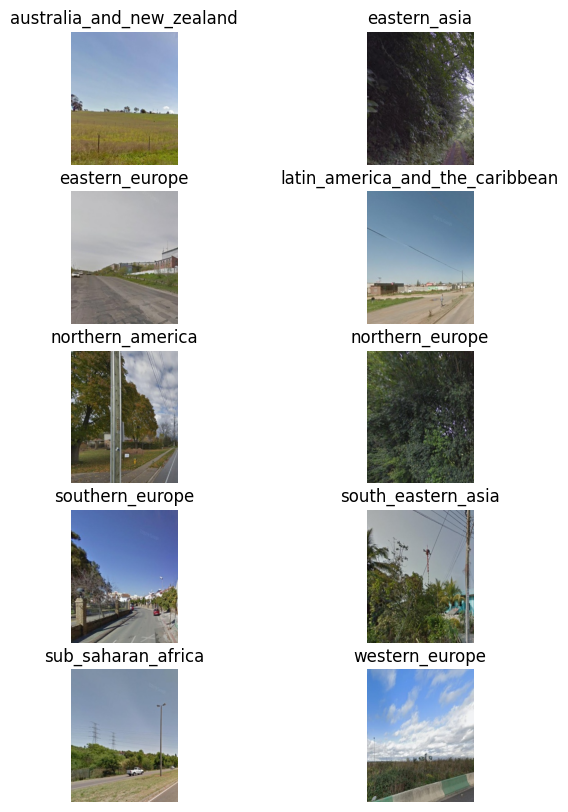

In [5]:

fig,axs = plt.subplots(5,2,figsize=(7,10))
for i, (label, img_list) in enumerate(label_img.items()):
    # Randomly sample image
    rand_path = np.random.choice(img_list)
    rand_pic = cv2.imread(rand_path)
    rand_pic = cv2.cvtColor(rand_pic, cv2.COLOR_BGR2RGB) # Converting back to correct color format cv.COLOR_BGR2GRAY
    axs[i//2,i%2].imshow(rand_pic)
    axs[i//2,i%2].axis('off')
    axs[i//2,i%2].set_title(label)

# Train-Val-Test Split

Ratio: 7-2-1

In [6]:
import shutil
# Stratified Sampling
validate_prop = 0.2
test_prop = 0.1
seed = 281
np.random.seed(seed)
dataset_path = 'content/cleaned_dataset'

train_imgs,validate_imgs,test_imgs = [],[],[]

if not os.path.exists('dataset_dir'):
    os.mkdir('dataset_dir')
if not os.path.exists('dataset_dir/train'):
    os.mkdir('dataset_dir/train')
if not os.path.exists('dataset_dir/validate'):
    os.mkdir('dataset_dir/validate')
if not os.path.exists('dataset_dir/test'):
    os.mkdir('dataset_dir/test')

for label in os.listdir(dataset_path):
    # List all images
    class_path = f'{dataset_path}/{label}'
    im_path = os.listdir(class_path)
    im_path = [f'{class_path}/{i}' for i in im_path]

    # We don't shuffle the paths for the general split so we can sample the 2 halves of the images together
    # np.random.shuffle(im_path)
    # For Debugging: LIMITING THE DATSET SIZE
    # im_path = im_path[:2000]

    # Split the first 70% for train
    train_pos = int(len(im_path)*(1-(validate_prop+test_prop)))
    validate_pos = train_pos+int(len(im_path)*validate_prop)
    train_path = im_path[:train_pos]
    val_path = im_path[train_pos:validate_pos]
    test_path = im_path[validate_pos:]

    if not os.path.exists(f'dataset_dir/train/{label}'):
        os.mkdir(f'dataset_dir/train/{label}')
        for i in train_path:
            shutil.copy(i,f'dataset_dir/train/{label}')

    if not os.path.exists(f'dataset_dir/validate/{label}'):
        os.mkdir(f'dataset_dir/validate/{label}')
        for i in val_path:
            shutil.copy(i,f'dataset_dir/validate/{label}')

    if not os.path.exists(f'dataset_dir/test/{label}'):
        os.mkdir(f'dataset_dir/test/{label}')
        for i in test_path:
            shutil.copy(i,f'dataset_dir/test/{label}')



    train_imgs+=train_path
    validate_imgs+=val_path
    test_imgs+=test_path


In [10]:
print(len(train_imgs))

54790


In [11]:
print(len(validate_imgs))

15650


In [12]:
print(len(test_imgs))

7840


# Feature Extraction and Checkpoints

In [11]:
import skimage.io as skio
from skimage.color import rgb2gray
from scipy.spatial import distance
import time

from sklearn.cluster import KMeans
# Feature extraction_pipeline
# General Preprocessing
def read_img(img_list):
    return skio.imread_collection(img_list)

# Get Hog
def get_hog(im_arr,pixels_per_cell=None,orientations=5,cells_per_block=(1,1)):
    hog_f_arr = []
    for im in im_arr:
        if pixels_per_cell is None:
            pixels_per_cell = (im.shape[1]/12,im.shape[0]/15)
        f = hog(im,pixels_per_cell=pixels_per_cell,visualize=False,orientations=orientations,channel_axis=-1,cells_per_block=cells_per_block)
        hog_f_arr.append(f)
    return np.array(hog_f_arr)

def compute_hist(lbp):
    hist = []
    for l in lbp:
        h,_ = np.histogram(l,bins=20,range=[0,256])
        hist.append(h/h.sum())
    return np.array(hist)

# Get LBP
def get_lbp(im_arr,P=8,R=10):
    lbp_f_arr = []
    gray_im_arr = rgb2gray(im_arr)
    for im in gray_im_arr:
        lbp_f_arr.append(lbp(im,P=P,R=R).ravel())
    return compute_hist(np.array(lbp_f_arr))

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense,Dropout,GlobalAveragePooling2D,RandomCrop
from tensorflow.keras.models import Model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

train_datagen = ImageDataGenerator(rescale=1./255,height_shift_range=0.0,rotation_range=0,)
validate_datagen = ImageDataGenerator(rescale=1./255,height_shift_range=0.0,rotation_range=0,)
test_datagen = ImageDataGenerator(rescale=1./255,height_shift_range=0.0,rotation_range=0,)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10548033734099631089
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6124732416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5762091457576742860
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-17 16:12:38.208571: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 16:12:38.208701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 16:12:38.208739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 16:12:38.209279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 16:12:38.209291: I tensorflow/core/common_runtime/gpu/gpu

In [13]:
# Pre-trained Models
from keras.applications import DenseNet121

def make_pretrained_model(input_shape=(293,235,3,),dense_size=32,num_classes=10,dropout=0.2):
    inputs = Input(shape=input_shape)
    # Crop to square image
    crop = RandomCrop(height=224,width=224)(inputs)

    pretrained_model = DenseNet121(include_top=False,
                        weights='imagenet',
                        input_shape=(224,224,3,),
                        )

    # Pretrained Feature Extractions
    ## Freezing pretrained_model weights
    for l in pretrained_model.layers[:-10]:
        l.trainable = False

    pretrained = pretrained_model(crop)
    ## freeze layers


    # Global pool
    flatten = GlobalAveragePooling2D()(pretrained)
    dropout = Dropout(dropout)(flatten)
    # Dense layers
    hidden = Dense(dense_size,activation='relu')(dropout)
    outputs = Dense(num_classes,activation='softmax')(hidden)

    model = Model(inputs=[inputs],outputs=[outputs])
    return model

In [14]:
pretrained_model = make_pretrained_model()
pretrained_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 293, 235, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_crop_1 (RandomCrop)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,070,634 (26.97 MB)

 Trainable params: 201,258 (786.16 KB)

 Non-trainable params: 6,869,376 (26.20 MB)

## Training Set

In [15]:
train_folder = 'dataset_dir/train'
class_folder = os.listdir(train_folder)

save_path = project_path + '/preprocessed_train_no_reduction/'

if not os.path.exists(save_path):
    os.mkdir(save_path)

In [31]:
train_folder = 'dataset_dir/train'
class_folder = os.listdir(train_folder)

lbp_features = []
labels = []
img_list_train = []

# LBP Embedding
start = time.time()
for l in class_folder:
    img_list = os.listdir(f'{train_folder}/{l}')
    img_list = [f'{train_folder}/{l}/{i}' for i in img_list]
    im_db = read_img(img_list)
    lbp_features.append(get_lbp(im_db))
    labels.append(np.repeat(l,len(img_list)))
    img_list_train.append(img_list)

print(f'Embedding training LBP took {time.time() - start} seconds')

np.save(f'{save_path}img_list.npy',np.concatenate(img_list_train))
np.save(f'{save_path}X_lbp.npy',np.row_stack(lbp_features))
np.save(f'{save_path}y.npy',np.concatenate(labels))

Exception ignored in: <function PluginV3.__del__ at 0x000001E60383BE20>
Traceback (most recent call last):
  File "C:\Users\River\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\imageio\core\v3_plugin_api.py", line 370, in __del__
    self.close()
  File "C:\Users\River\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\imageio\plugins\pillow.py", line 144, in close
    self._flush_writer()
  File "C:\Users\River\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\imageio\plugins\pillow.py", line 476, in _flush_writer
    if len(self.images_to_write) == 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'PillowPlugin' object has no attribute 'images_to_write'


Embedding training LBP took 767.9254579544067 seconds


In [32]:
hog_features = []

# HOG Embedding
start = time.time()
for l in class_folder:
    img_list = os.listdir(f'{train_folder}/{l}')
    img_list = [f'{train_folder}/{l}/{i}' for i in img_list]
    im_db = read_img(img_list)
    hog_features.append(get_hog(im_db))

print(f'Embedding training HOG took {time.time() - start} seconds')

np.save(f'{save_path}X_hog.npy',np.row_stack(hog_features))

Embedding training HOG took 785.220579624176 seconds


In [16]:
# CNN embedding
BATCH_SIZE = 64
clone_model = tf.keras.models.Model(inputs=pretrained_model.inputs, outputs = pretrained_model.layers[3].output)
feat_generator = train_datagen.flow_from_directory(train_folder, batch_size=BATCH_SIZE, target_size=(293,235), shuffle=False)

start = time.time()
cnn_features = []
for i in range(len(feat_generator)):
    # The other notebook had feat_generator.next() but that isn't an available function on my installation
    # So I refactored it to use the private method below
    cnn_features.extend(clone_model.predict(feat_generator.__getitem__(i)[0]))

print(f'Embedding training CNN took {time.time() - start} seconds')

np.save(f'{save_path}X_cnn.npy',np.row_stack(cnn_features))

Found 54790 images belonging to 10 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 

In [19]:
print(cnn_features[0].shape)

(1024,)


## Validation Set

In [20]:
validate_folder = 'dataset_dir/validate'
class_folder = os.listdir(validate_folder)

save_path = project_path + '/preprocessed_validate_no_reduction/'

if not os.path.exists(save_path):
    os.mkdir(save_path)

In [21]:
lbp_features = []
labels = []
img_list_all = []

# LBP Embedding
start = time.time()
for l in class_folder:
    img_list = os.listdir(f'{validate_folder}/{l}')
    img_list = [f'{validate_folder}/{l}/{i}' for i in img_list]
    im_db = read_img(img_list)
    lbp_features.append(get_lbp(im_db))
    labels.append(np.repeat(l,len(img_list)))
    img_list_all.append(img_list)

print(f'Embedding validation LBP took {time.time() - start} seconds')

np.save(f'{save_path}img_list.npy',np.concatenate(img_list_all))
np.save(f'{save_path}X_lbp.npy',np.row_stack(lbp_features))
np.save(f'{save_path}y.npy',np.concatenate(labels))

/home/river/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Embedding validation LBP took 244.22949814796448 seconds


In [22]:
hog_features = []

# HOG Embedding
start = time.time()
for l in class_folder:
    img_list = os.listdir(f'{validate_folder}/{l}')
    img_list = [f'{validate_folder}/{l}/{i}' for i in img_list]
    im_db = read_img(img_list)
    hog_features.append(get_hog(im_db))

print(f'Embedding validation HOG took {time.time() - start} seconds')

np.save(f'{save_path}X_hog.npy',np.row_stack(hog_features))

Embedding validation HOG took 353.24582052230835 seconds


In [23]:
# CNN embedding
val_generator = validate_datagen.flow_from_directory(validate_folder, batch_size=BATCH_SIZE, target_size=(293,235), shuffle=False)

start = time.time()
cnn_features = []
for i in range(len(val_generator)):
    # The other notebook had feat_generator.next() but that isn't an available function on my installation
    # So I refactored it to use the private method below
    cnn_features.extend(clone_model.predict(val_generator.__getitem__(i)[0]))

print(f'Embedding validation CNN took {time.time() - start} seconds')

np.save(f'{save_path}X_cnn.npy',np.row_stack(cnn_features))

Found 15650 images belonging to 10 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2

In [24]:
print(len(lbp_features))
print(len(hog_features))
print(len(cnn_features))
print(len(labels))
print(len(img_list_all))

10
10
15650
10
10


In [33]:
print(len(lbp_features[0][0]))
print(len(hog_features[0][0]))

20
840


## Test Set

In [34]:
test_folder = 'dataset_dir/test'
class_folder = os.listdir(test_folder)

save_path = project_path + '/preprocessed_test_no_reduction/'

if not os.path.exists(save_path):
    os.mkdir(save_path)

In [35]:
lbp_features = []
labels = []
img_list_all = []

# LBP Embedding
start = time.time()
for l in class_folder:
    img_list = os.listdir(f'{test_folder}/{l}')
    img_list = [f'{test_folder}/{l}/{i}' for i in img_list]
    im_db = read_img(img_list)
    lbp_features.append(get_lbp(im_db))
    labels.append(np.repeat(l,len(img_list)))
    img_list_all.append(img_list)

print(f'Embedding test LBP took {time.time() - start} seconds')

np.save(f'{save_path}img_list.npy',np.concatenate(img_list_all))
np.save(f'{save_path}X_lbp.npy',np.row_stack(lbp_features))
np.save(f'{save_path}y.npy',np.concatenate(labels))

/home/river/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Embedding test LBP took 123.43517136573792 seconds


In [36]:
hog_features = []

# HOG Embedding
start = time.time()
for l in class_folder:
    img_list = os.listdir(f'{test_folder}/{l}')
    img_list = [f'{test_folder}/{l}/{i}' for i in img_list]
    im_db = read_img(img_list)
    hog_features.append(get_hog(im_db))

print(f'Embedding test HOG took {time.time() - start} seconds')

np.save(f'{save_path}X_hog.npy',np.row_stack(hog_features))

Embedding test HOG took 177.88852620124817 seconds


In [252]:
# CNN embedding
test_generator = test_datagen.flow_from_directory(test_folder, batch_size=BATCH_SIZE, target_size=(293,235), shuffle=False)

start = time.time()
cnn_features = []
for i in range(len(test_generator)):
    # The other notebook had feat_generator.next() but that isn't an available function on my installation
    # So I refactored it to use the private method below
    cnn_features.extend(clone_model.predict(test_generator.__getitem__(i)[0]))

print(f'Embedding test CNN took {time.time() - start} seconds')

np.save(f'{save_path}X_cnn.npy',np.row_stack(cnn_features))

Found 7840 images belonging to 10 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s

# Load Train/Val Checkpoint here

In [253]:
# Load features file

# Train
hog_train_X = np.load(project_path + '/preprocessed_train_no_reduction/X_hog.npy')
lbp_train_X = np.load(project_path + '/preprocessed_train_no_reduction/X_lbp.npy')
cnn_train_X = np.load(project_path + '/preprocessed_train_no_reduction/X_cnn.npy')
train_y = np.load(project_path + '/preprocessed_train_no_reduction/y.npy')

# Validation
hog_val_X = np.load(project_path + '/preprocessed_validate_no_reduction/X_hog.npy')
lbp_val_X = np.load(project_path + '/preprocessed_validate_no_reduction/X_lbp.npy')
cnn_val_X = np.load(project_path + '/preprocessed_validate_no_reduction/X_cnn.npy')
val_y = np.load(project_path + '/preprocessed_validate_no_reduction/y.npy')

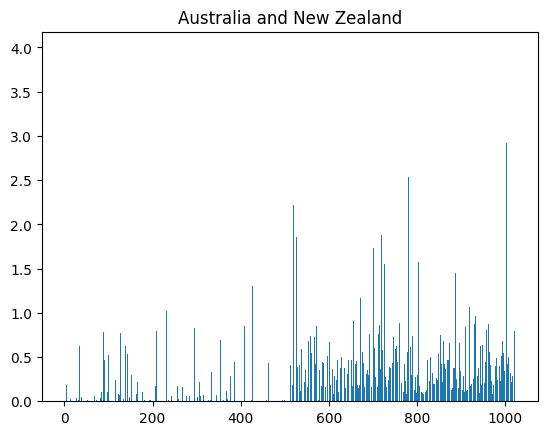

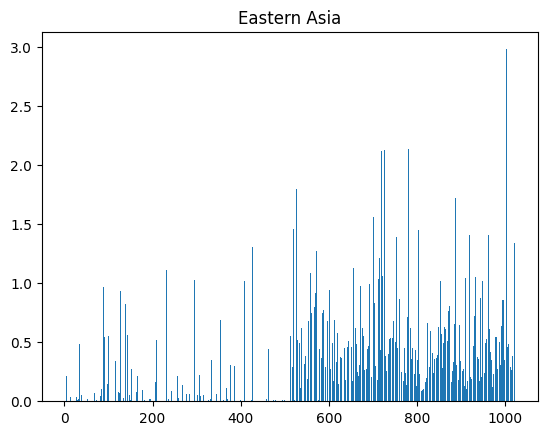

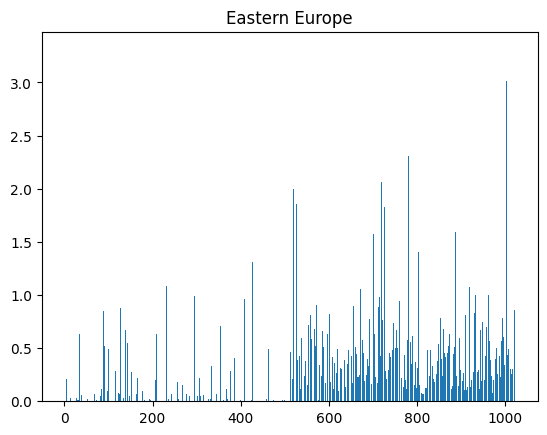

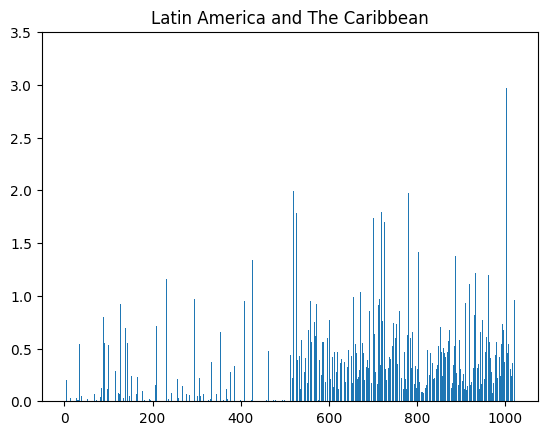

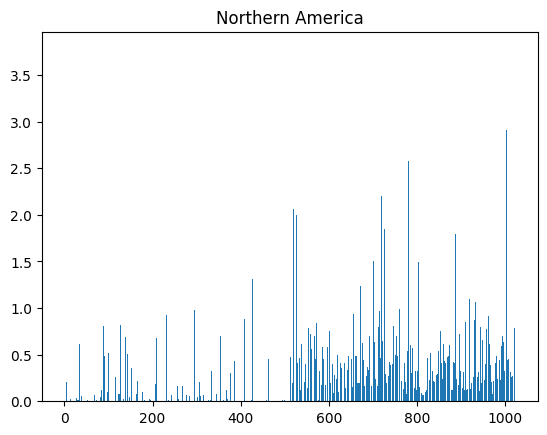

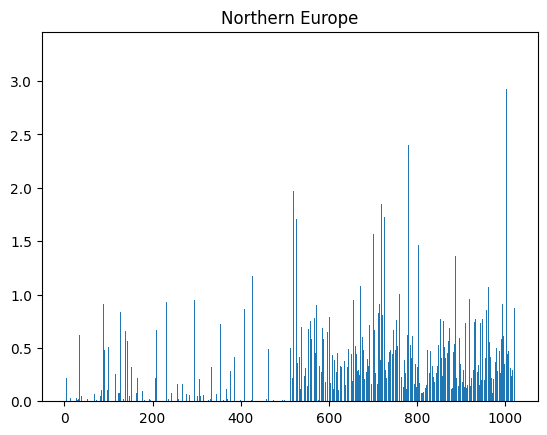

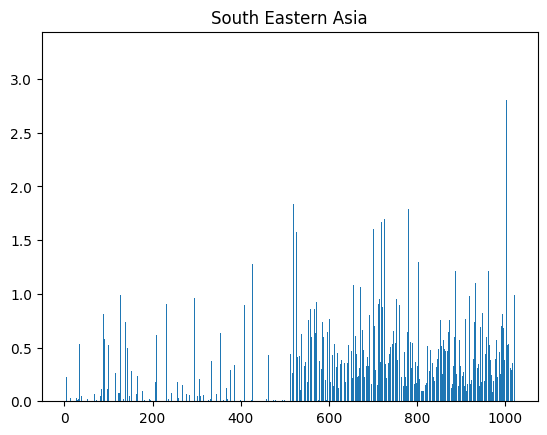

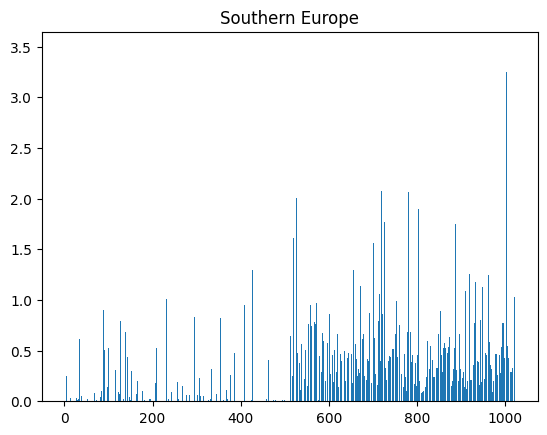

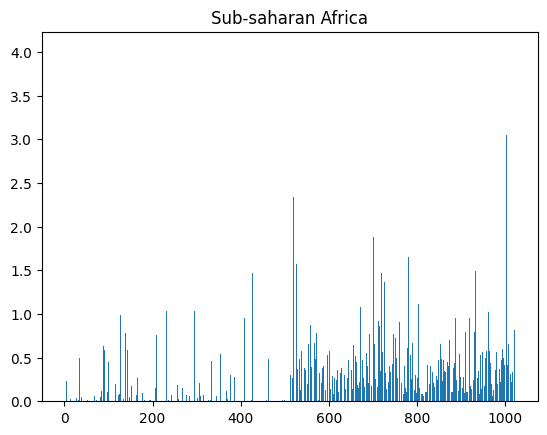

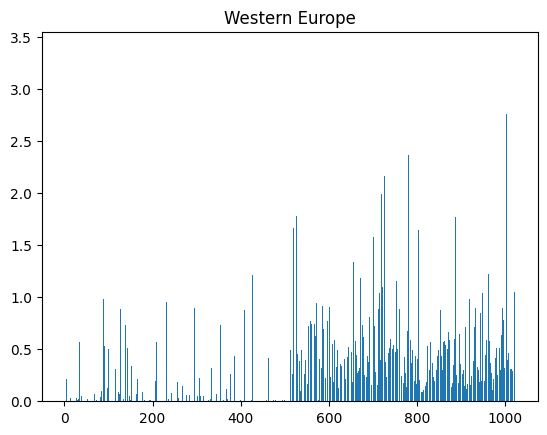

In [228]:
average_cnn_features = np.zeros((10, cnn_train_X.shape[1]))
average_cnn_features[0] = np.average(cnn_train_X[train_y == 'australia_and_new_zealand'], axis=0)
average_cnn_features[1] = np.average(cnn_train_X[train_y == 'eastern_asia'], axis=0)
average_cnn_features[2] = np.average(cnn_train_X[train_y == 'eastern_europe'], axis=0)
average_cnn_features[3] = np.average(cnn_train_X[train_y == 'latin_america_and_the_caribbean'], axis=0)
average_cnn_features[4] = np.average(cnn_train_X[train_y == 'northern_america'], axis=0)
average_cnn_features[5] = np.average(cnn_train_X[train_y == 'northern_europe'], axis=0)
average_cnn_features[6] = np.average(cnn_train_X[train_y == 'south_eastern_asia'], axis=0)
average_cnn_features[7] = np.average(cnn_train_X[train_y == 'southern_europe'], axis=0)
average_cnn_features[8] = np.average(cnn_train_X[train_y == 'sub_saharan_africa'], axis=0)
average_cnn_features[9] = np.average(cnn_train_X[train_y == 'western_europe'], axis=0)

plot_indexes = [i for i in range(cnn_train_X.shape[1])]
plt.bar(plot_indexes, average_cnn_features[0])
plt.title('Australia and New Zealand')
plt.show()

plt.bar(plot_indexes, average_cnn_features[1])
plt.title('Eastern Asia')
plt.show()

plt.bar(plot_indexes, average_cnn_features[2])
plt.title('Eastern Europe')
plt.show()

plt.bar(plot_indexes, average_cnn_features[3])
plt.title('Latin America and The Caribbean')
plt.show()

plt.bar(plot_indexes, average_cnn_features[4])
plt.title('Northern America')
plt.show()

plt.bar(plot_indexes, average_cnn_features[5])
plt.title('Northern Europe')
plt.show()

plt.bar(plot_indexes, average_cnn_features[6])
plt.title('South Eastern Asia')
plt.show()

plt.bar(plot_indexes, average_cnn_features[7])
plt.title('Southern Europe')
plt.show()

plt.bar(plot_indexes, average_cnn_features[8])
plt.title('Sub-saharan Africa')
plt.show()

plt.bar(plot_indexes, average_cnn_features[9])
plt.title('Western Europe')
plt.show()

# PCA/t-SNE Analysis

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

In [39]:
hog_pca_pipe = Pipeline([('scaler',RobustScaler()),
 ('pca',PCA(n_components=2))])

X_hog_pca = hog_pca_pipe.fit_transform(hog_train_X.astype(np.float32))

hog_tsne_pipe = Pipeline([('scaler',RobustScaler()),
 ('tsne',TSNE(n_iter=5000,n_components=2,random_state=1,method='barnes_hut'))])

X_hog_tsne = hog_tsne_pipe.fit_transform(hog_train_X.astype(np.float32))

In [40]:
lbp_pca_pipe = Pipeline([('scaler',RobustScaler()),
  ('pca', PCA(n_components=2))])

X_lbp_pca = lbp_pca_pipe.fit_transform(lbp_train_X.astype(np.float32))

lbp_tsne_pipe = Pipeline([('scaler',RobustScaler()),
  ('tsne',TSNE(n_iter=5000,n_components=2,random_state=1,method='barnes_hut'))])

X_lbp_tsne = lbp_tsne_pipe.fit_transform(lbp_train_X.astype(np.float32))

In [44]:
cnn_pca_pipe = Pipeline([('scaler',RobustScaler()),
  ('pca', PCA(n_components=2))])

X_cnn_pca = cnn_pca_pipe.fit_transform(cnn_train_X.astype(np.float32))

cnn_tsne_pipe = Pipeline([('scaler',RobustScaler()),
  ('tsne',TSNE(n_iter=5000,n_components=2,random_state=1,method='barnes_hut'))])

X_cnn_tsne = cnn_tsne_pipe.fit_transform(cnn_train_X.astype(np.float32))

In [45]:
import seaborn as sns

# Plot methods
country_id_mapping = {v:k for k,v in dict(enumerate(np.unique(train_y))).items()}

def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
  # project the features into 2 dimensions

  for i,k in country_id_mapping.items():
    #print(i)
    sns.scatterplot(x = X[y==i, 0], y = X[y==i, 1],ax=ax)

  ax.set_title(title)

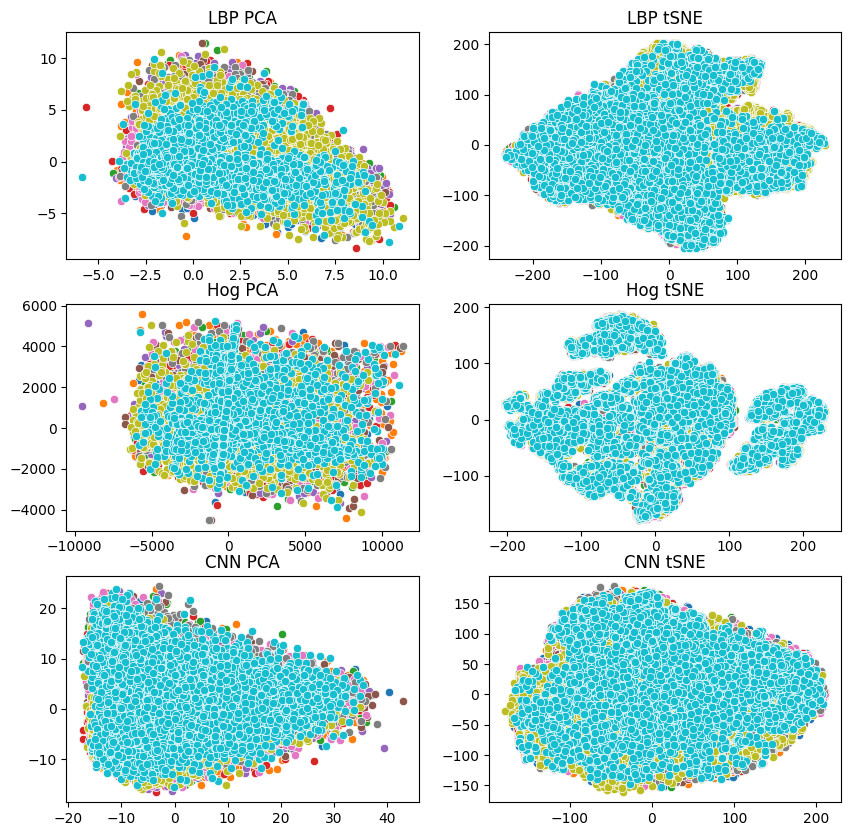

In [47]:
# plot results
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# plot just a sample of each
#sample_size = 1000
plot_classes(X_hog_pca, train_y, ax[1,0], title='Hog PCA')
plot_classes(X_lbp_pca, train_y, ax[0,0], title='LBP PCA')
plot_classes(X_hog_tsne, train_y, ax[1,1], title='Hog tSNE')
plot_classes(X_lbp_tsne, train_y, ax[0,1], title='LBP tSNE')
plot_classes(X_cnn_pca, train_y, ax[2,0], title='CNN PCA')
plot_classes(X_cnn_tsne, train_y, ax[2,1], title='CNN tSNE')

plt.show()

In [48]:
lbp_train_X.shape

(54790, 20)

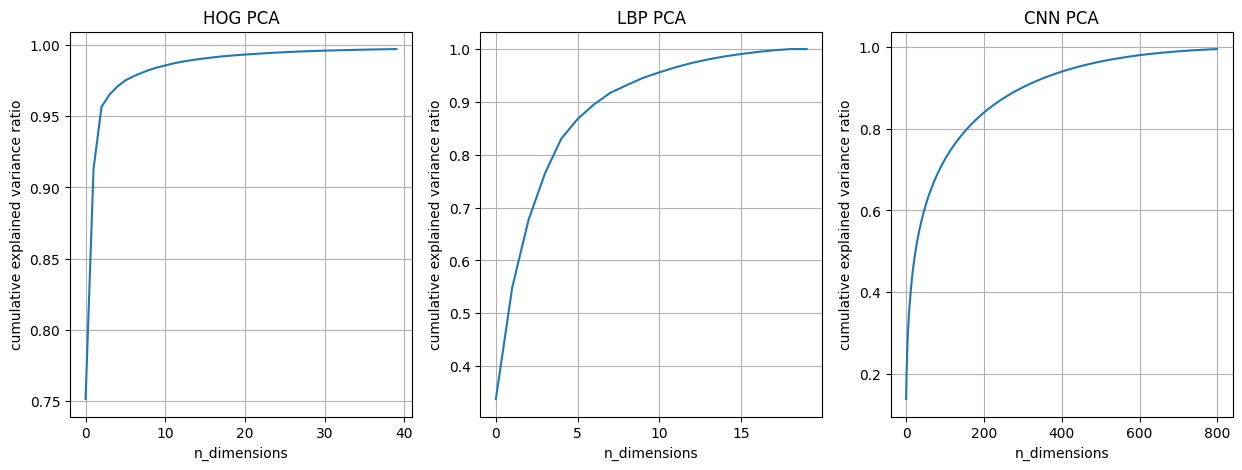

In [55]:
# PCA Curves
hog_pca_pipe = Pipeline([('scaler',RobustScaler()),
 ('pca',PCA(n_components=40))])

X_hog_pca = hog_pca_pipe.fit_transform(hog_train_X.astype(np.float32))


lbp_pca_pipe = Pipeline([('scaler',RobustScaler()),
  ('pca', PCA(n_components=20))])

X_lbp_pca = lbp_pca_pipe.fit_transform(lbp_train_X.astype(np.float32))

cnn_pca_pipe = Pipeline([('scaler',RobustScaler()),
  ('pca', PCA(n_components=800))])

X_cnn_pca = cnn_pca_pipe.fit_transform(cnn_train_X.astype(np.float32))

def plot_pca_curve(pca_model, label, ax, title):
  ax.plot(np.cumsum(pca_model.explained_variance_ratio_),label=label)
  ax.set_xlabel('n_dimensions')
  ax.set_ylabel('cumulative explained variance ratio')
  ax.set_title(title)
  ax.grid(visible=True)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

plot_pca_curve(hog_pca_pipe['pca'], 'hog_features', ax[0], title='HOG PCA')
plot_pca_curve(lbp_pca_pipe['pca'], 'lbp_features', ax[1], title='LBP PCA')
plot_pca_curve(cnn_pca_pipe['pca'], 'cnn_features', ax[2], title='CNN PCA')

plt.show()

# Classifiers

In [140]:
# Confusion Matrix Plot
import seaborn as sns

def plot_cm(model, X, y, title="Confusion Matrix"):
  predictions = model.predict(X)
  conf_mat = confusion_matrix(y, predictions)
  sns.heatmap(conf_mat/np.sum(conf_mat),annot=True,fmt='.1%',cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y)
            )
  plt.title(title)
  plt.show()

def plot_cm_pred(y_pred, y, title="Confusion Matrix"):
  conf_mat = confusion_matrix(y, y_pred)
  sns.heatmap(conf_mat/np.sum(conf_mat),annot=True,fmt='.1%',cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y)
            )
  plt.title(title)
  plt.show()

## Logistic Regression

In [141]:
# HOG Pipeline

hog_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])
start = time.time()
hog_lr.fit(hog_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",hog_lr.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_lr.score(hog_val_X, val_y))

Time: 28.761539459228516
Training Accuracy:  0.24694287278700494
Validation Accuracy:  0.19271565495207668


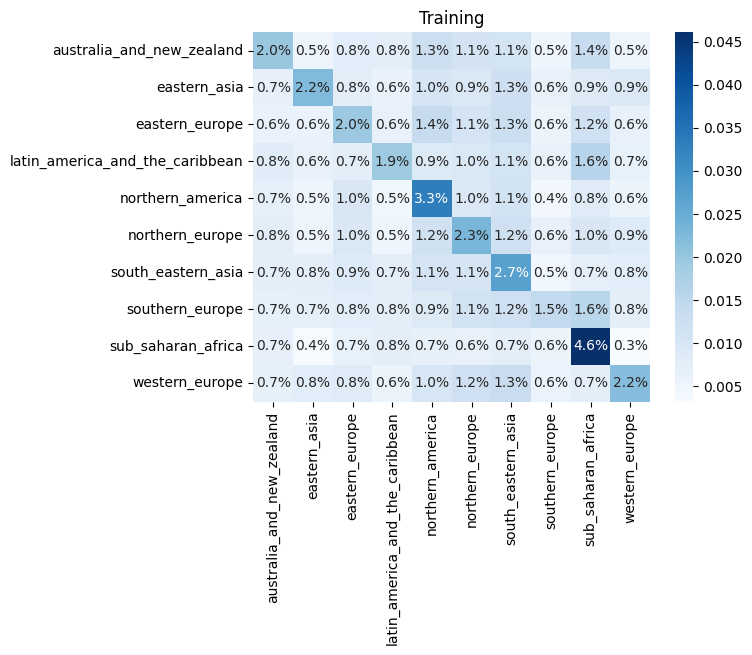

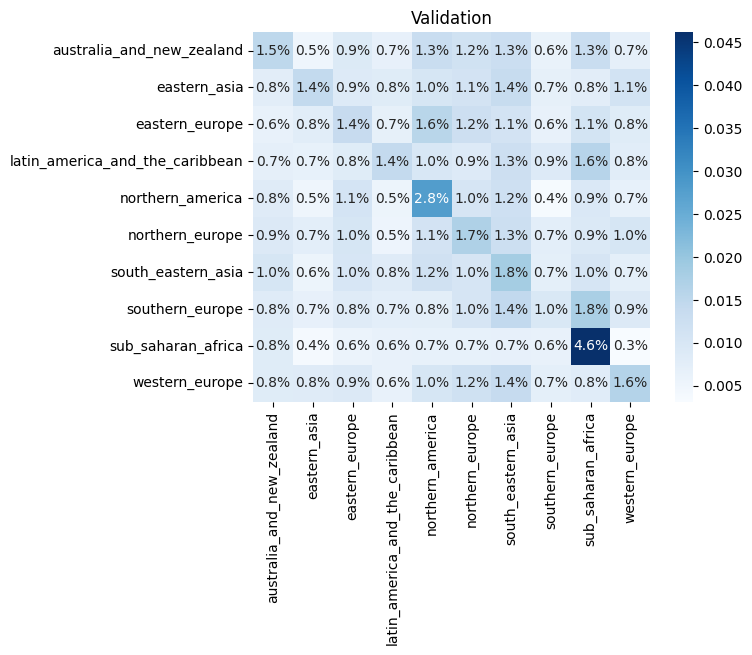

In [142]:
# Confusion Matrix
# fig, ax = plt.subplots(nrows=1, ncols=2)
# ax[0] = ConfusionMatrixDisplay.from_estimator(hog_lr, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# ax[0].set_title("Training")
# ax[1] = ConfusionMatrixDisplay.from_estimator(hog_lr, hog_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# ax[0].set_title("Validation")
# plt.show()

plot_cm(hog_lr, hog_train_X, train_y, "Training")
plot_cm(hog_lr, hog_val_X, val_y, "Validation")

In [143]:
hog_pca_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])

start = time.time()
hog_pca_lr.fit(hog_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",hog_pca_lr.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_pca_lr.score(hog_val_X, val_y))

Time: 4.384836673736572
Training Accuracy:  0.1391129768205877
Validation Accuracy:  0.1435143769968051


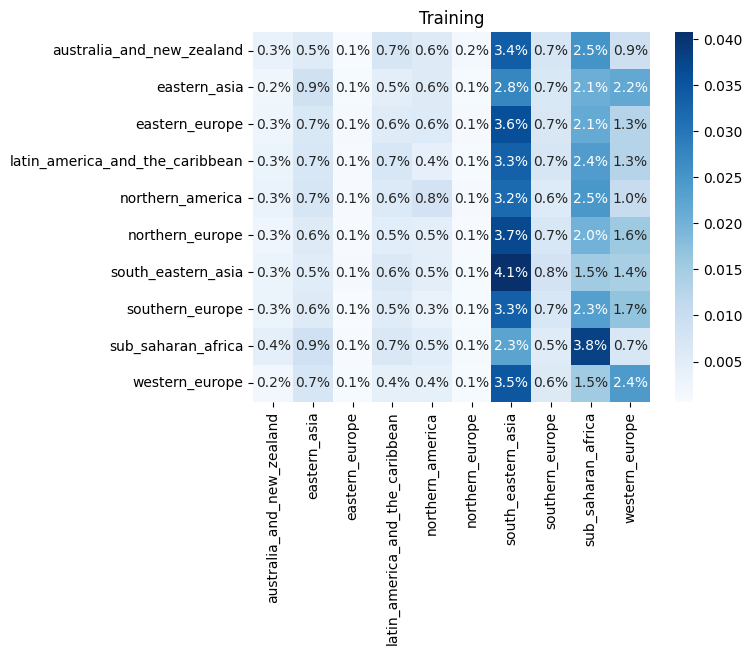

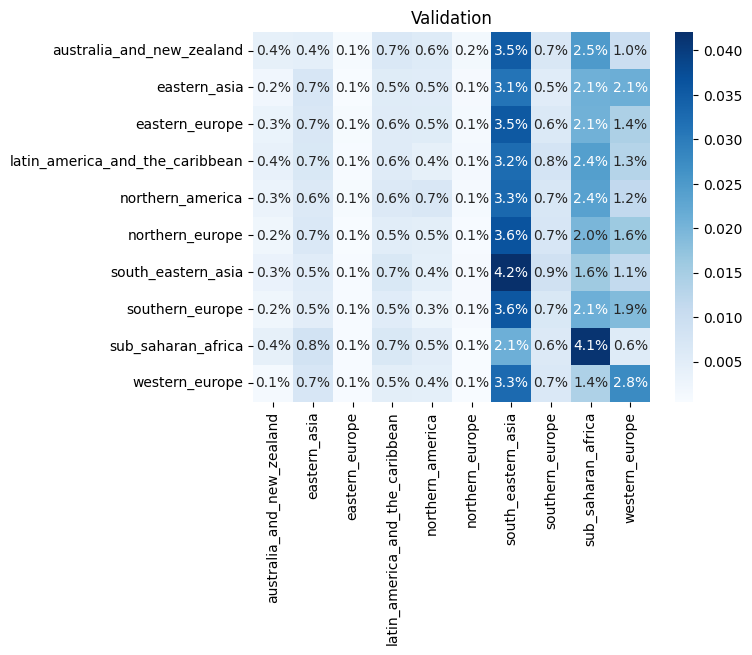

In [144]:
# hog_pca_lr_cm_train = ConfusionMatrixDisplay.from_estimator(hog_pca_lr, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()
plot_cm(hog_pca_lr, hog_train_X, train_y, "Training")
plot_cm(hog_pca_lr, hog_val_X, val_y, "Validation")

In [145]:
# LBP Pipeline
lbp_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])

start = time.time()
lbp_lr.fit(lbp_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",lbp_lr.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_lr.score(lbp_val_X, val_y))

Time: 1.023247480392456
Training Accuracy:  0.1962401898156598
Validation Accuracy:  0.18338658146964856


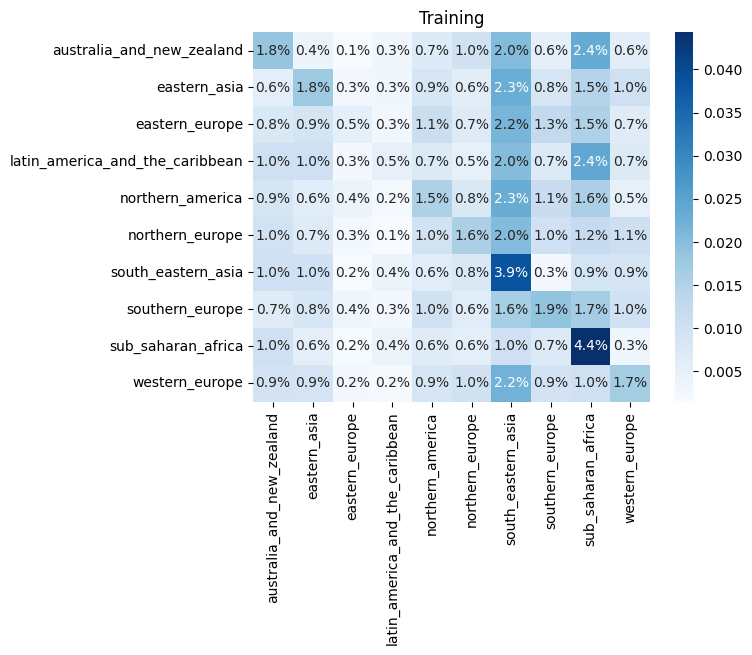

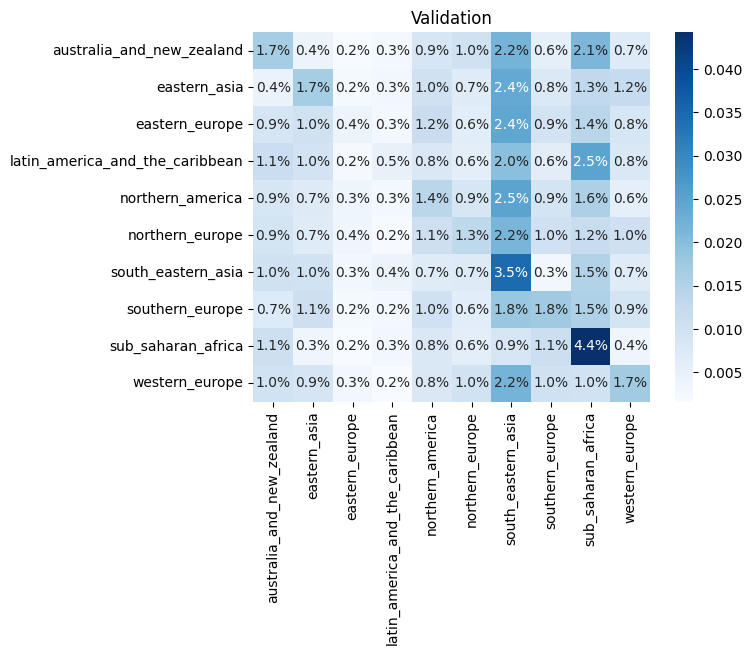

In [146]:
# lbp_lr_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_lr, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()
plot_cm(lbp_lr, lbp_train_X, train_y, "Training")
plot_cm(lbp_lr, lbp_val_X, val_y, "Validation")

In [147]:
lbp_pca_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])

start = time.time()
lbp_pca_lr.fit(lbp_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",lbp_pca_lr.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_pca_lr.score(lbp_val_X, val_y))

Time: 1.1882731914520264
Training Accuracy:  0.1796495710896149
Validation Accuracy:  0.17028753993610224


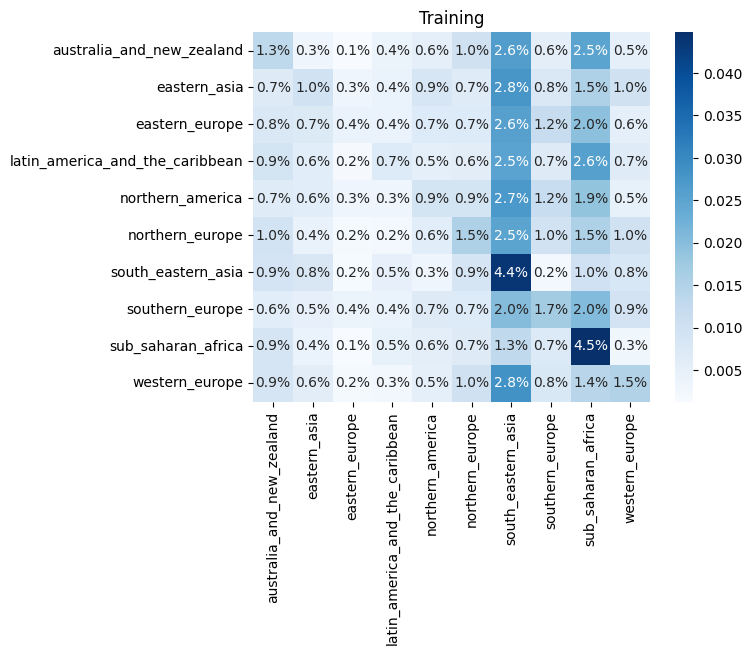

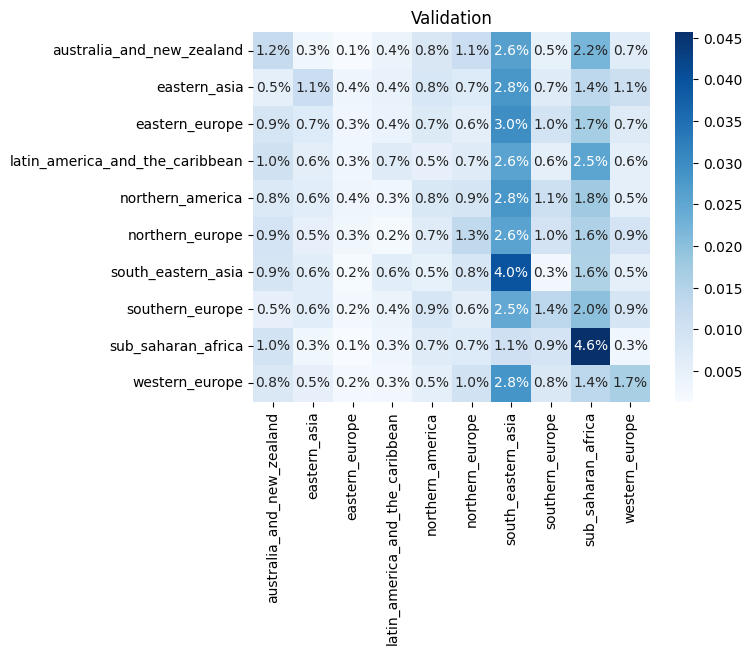

In [148]:
# lbp_pca_lr_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_pca_lr, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

plot_cm(lbp_pca_lr, lbp_train_X, train_y, "Training")
plot_cm(lbp_pca_lr, lbp_val_X, val_y, "Validation")

In [149]:
# LBP Pipeline
cnn_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])

start = time.time()
cnn_lr.fit(cnn_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",cnn_lr.score(cnn_train_X, train_y))
print("Validation Accuracy: ",cnn_lr.score(cnn_val_X, val_y))

Time: 22.125038385391235
Training Accuracy:  0.523270669830261
Validation Accuracy:  0.46907348242811503


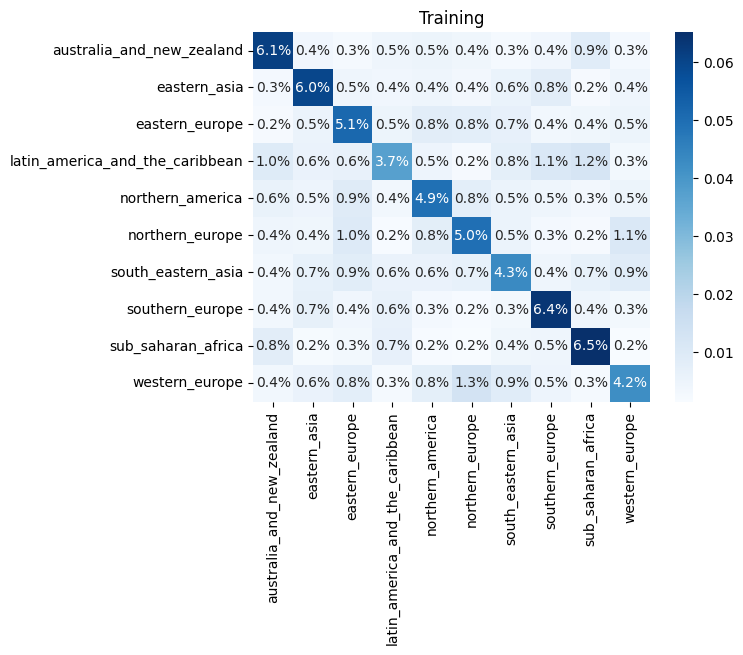

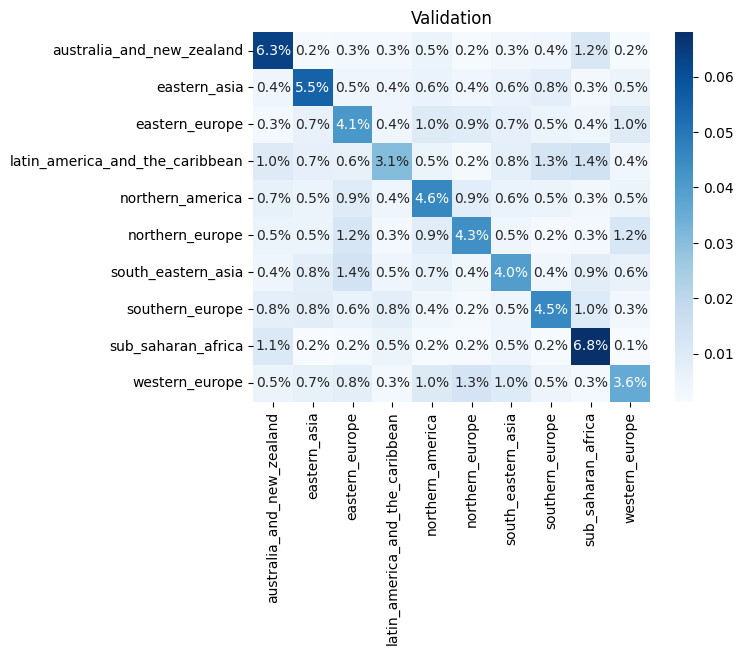

In [150]:
plot_cm(cnn_lr, cnn_train_X, train_y, "Training")
plot_cm(cnn_lr, cnn_val_X, val_y, "Validation")

In [151]:
# LBP Pipeline
cnn_pca_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=600)),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])

start = time.time()
cnn_pca_lr.fit(cnn_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",cnn_pca_lr.score(cnn_train_X, train_y))
print("Validation Accuracy: ",cnn_pca_lr.score(cnn_val_X, val_y))

Time: 17.692323684692383
Training Accuracy:  0.4771126117904727
Validation Accuracy:  0.44236421725239616


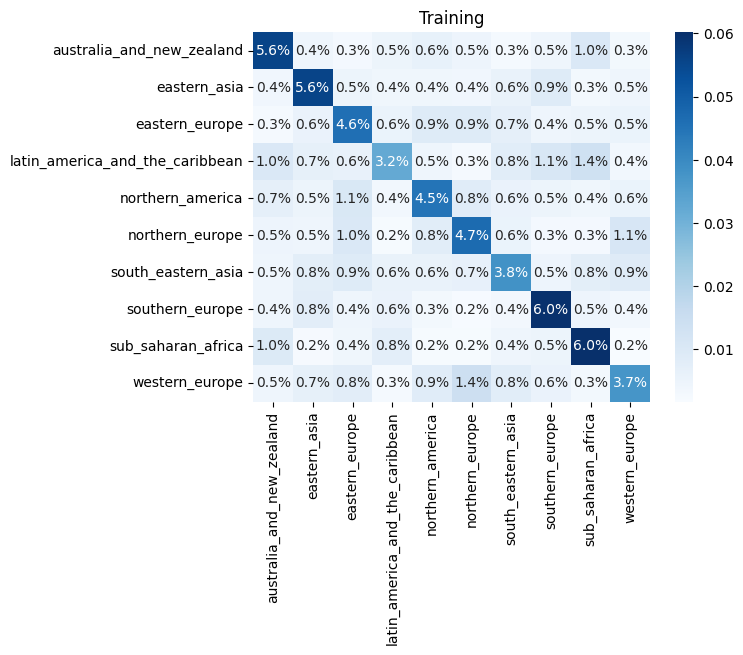

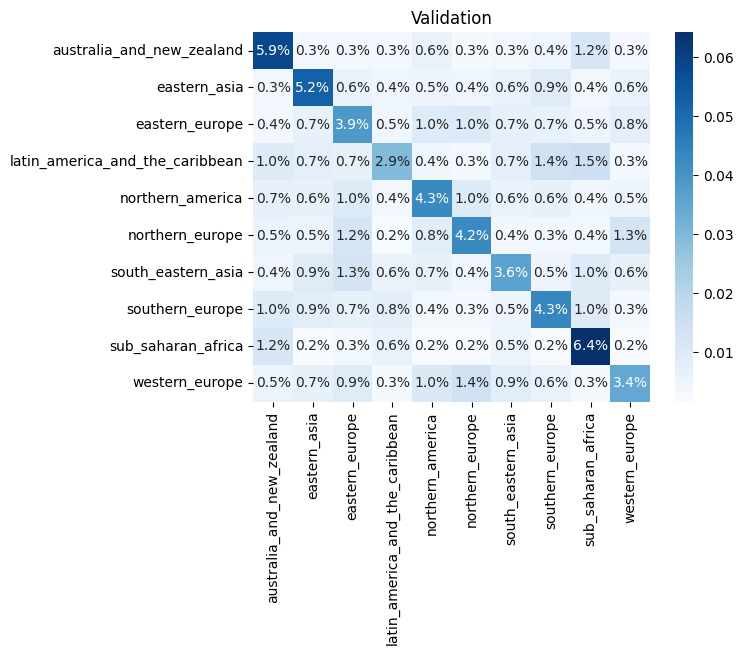

In [152]:
plot_cm(cnn_pca_lr, cnn_train_X, train_y, "Training")
plot_cm(cnn_pca_lr, cnn_val_X, val_y, "Validation")

## HistGradientBoost

In [153]:
hog_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
    ('clf', HistGradientBoostingClassifier(early_stopping=True,
                                               tol=100.0))
])

start = time.time()
hog_hgb.fit(hog_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",hog_hgb.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_hgb.score(hog_val_X, val_y))

Time: 3.5204195976257324
Training Accuracy:  0.21795948165723672
Validation Accuracy:  0.15648562300319488


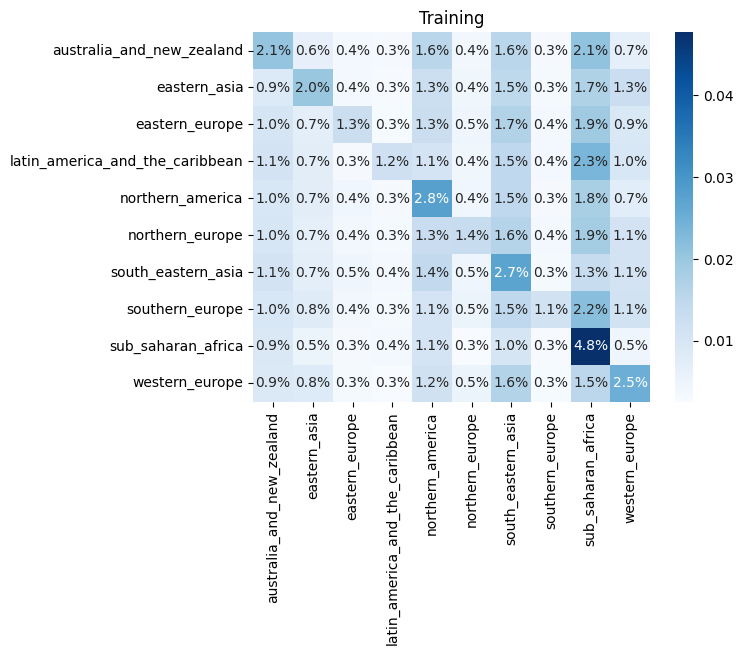

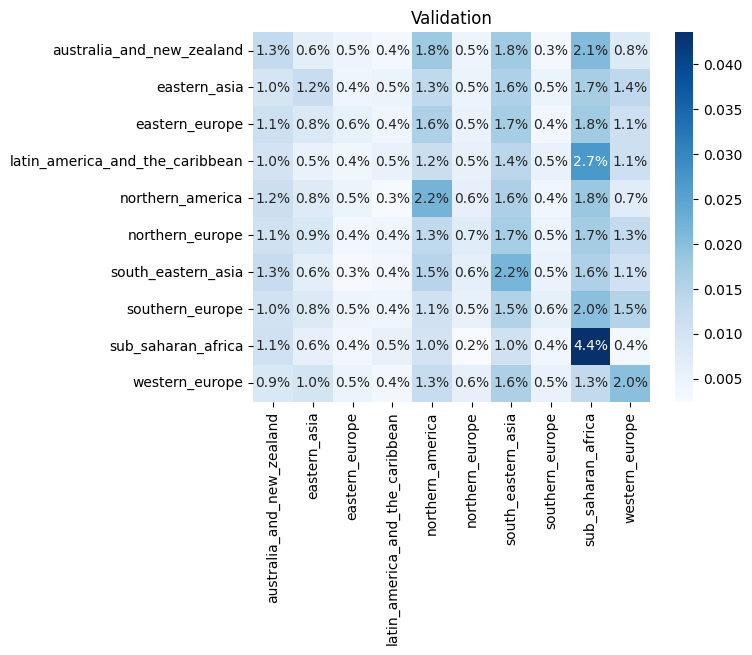

In [154]:
plot_cm(hog_hgb, hog_train_X, train_y, "Training")
plot_cm(hog_hgb, hog_val_X, val_y, "Validation")
# hog_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(hog_hgb, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# hog_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(hog_hgb, hog_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

In [155]:
hog_pca_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=20)),
    ('clf', HistGradientBoostingClassifier(early_stopping=True,
                                               tol=10.0))
])

start = time.time()
hog_pca_hgb.fit(hog_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",hog_pca_hgb.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_pca_hgb.score(hog_val_X, val_y))

Time: 3.6812727451324463
Training Accuracy:  0.23823690454462493
Validation Accuracy:  0.1602555910543131


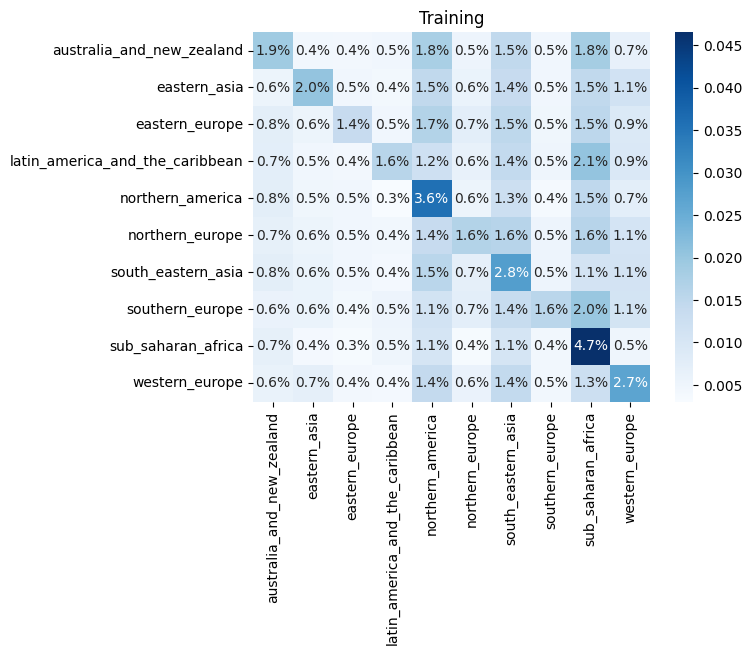

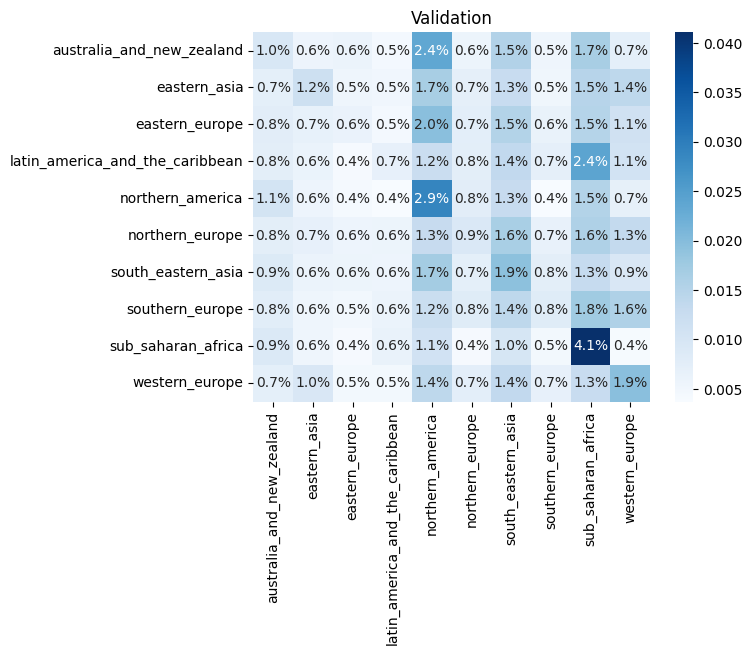

In [156]:
plot_cm(hog_pca_hgb, hog_train_X, train_y, "Training")
plot_cm(hog_pca_hgb, hog_val_X, val_y, "Validation")
# hog_pca_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(hog_pca_hgb, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# hog_pca_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(hog_pca_hgb, hog_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [157]:
lbp_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', HistGradientBoostingClassifier(early_stopping=True))
])

start = time.time()
lbp_hgb.fit(lbp_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",lbp_hgb.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_hgb.score(lbp_val_X, val_y))

Time: 2.4364259243011475
Training Accuracy:  0.4308267932104399
Validation Accuracy:  0.20869009584664536


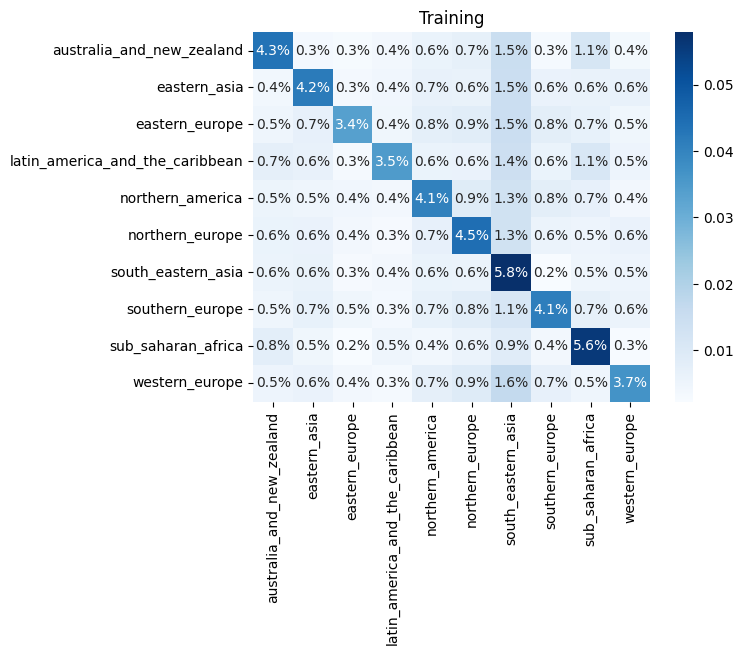

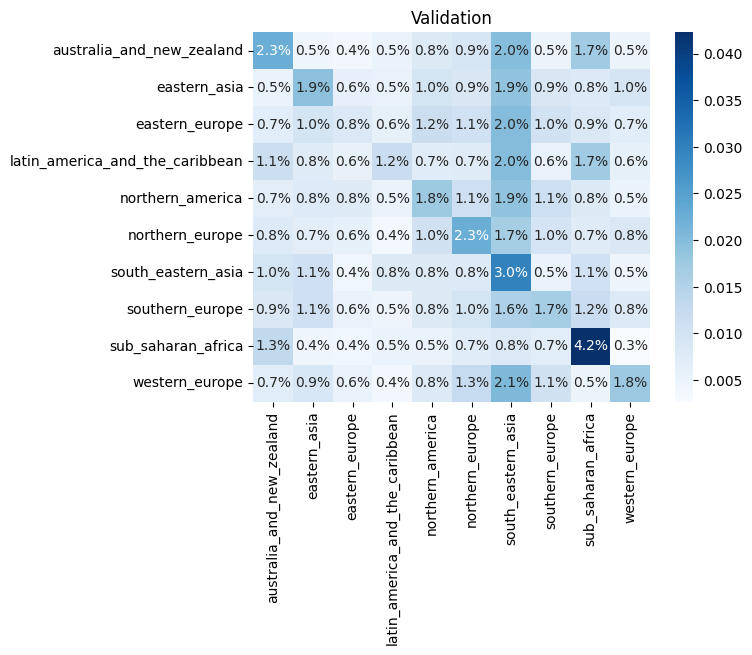

In [158]:
plot_cm(lbp_hgb, lbp_train_X, train_y, "Training")
plot_cm(lbp_hgb, lbp_val_X, val_y, "Validation")
# lbp_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_hgb, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# lbp_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(lbp_hgb, lbp_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

In [159]:
lbp_pca_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=20)),
    ('clf', HistGradientBoostingClassifier(early_stopping=True))
])

start = time.time()
lbp_pca_hgb.fit(lbp_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",lbp_pca_hgb.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_pca_hgb.score(lbp_val_X, val_y))

Time: 3.1135294437408447
Training Accuracy:  0.3993246942872787
Validation Accuracy:  0.20095846645367413


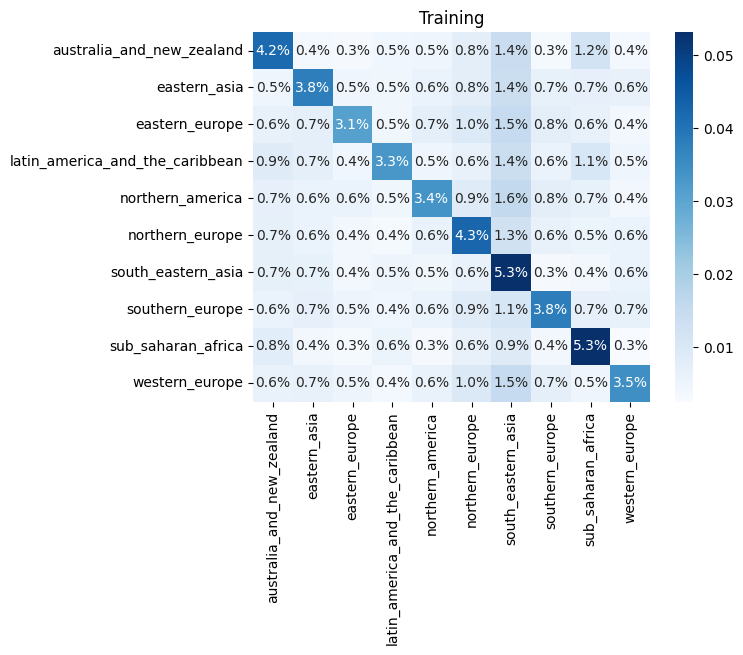

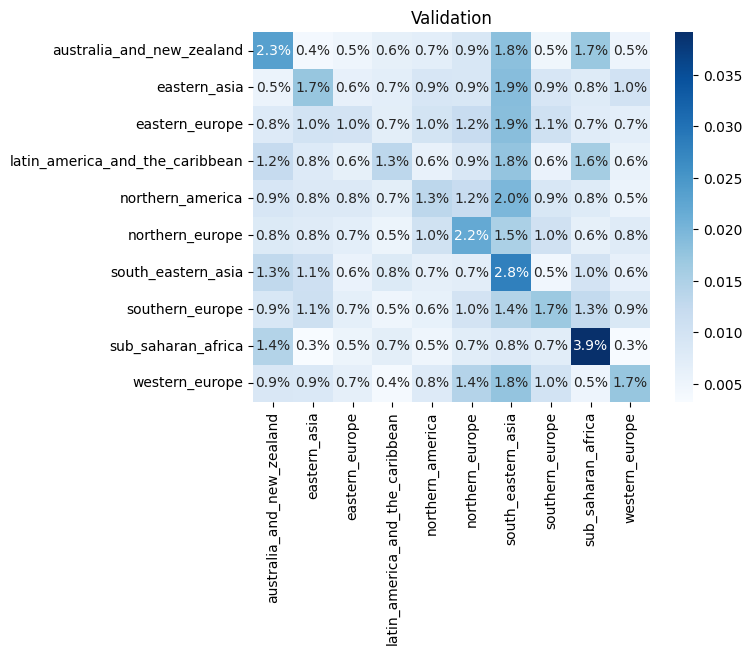

In [160]:
plot_cm(lbp_pca_hgb, lbp_train_X, train_y, "Training")
plot_cm(lbp_pca_hgb, lbp_val_X, val_y, "Validation")

# lbp_pca_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_pca_hgb, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# lbp_pca_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(lbp_pca_hgb, lbp_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

In [161]:
# CNN Pipeline
cnn_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', HistGradientBoostingClassifier(early_stopping=True))
])

start = time.time()
cnn_hgb.fit(cnn_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",cnn_lr.score(cnn_train_X, train_y))
print("Validation Accuracy: ",cnn_lr.score(cnn_val_X, val_y))

Time: 90.40737509727478
Training Accuracy:  0.523270669830261
Validation Accuracy:  0.46907348242811503


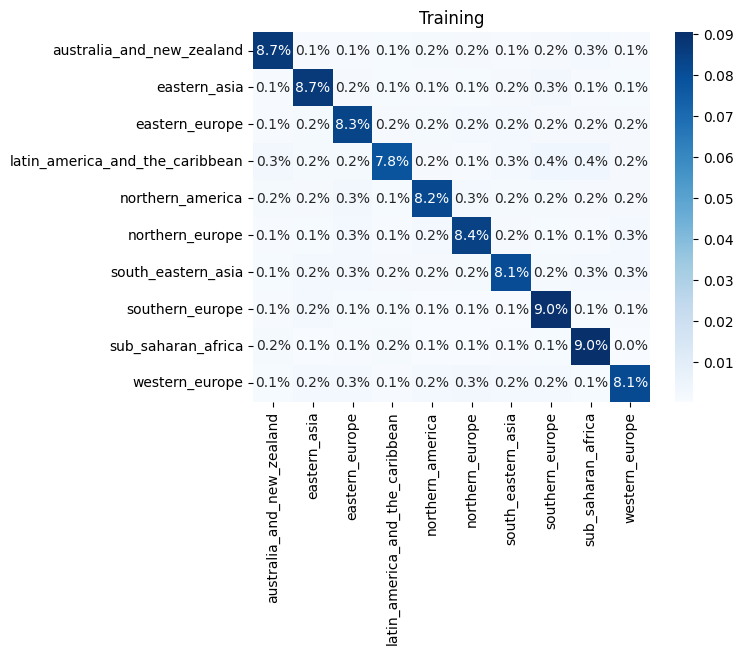

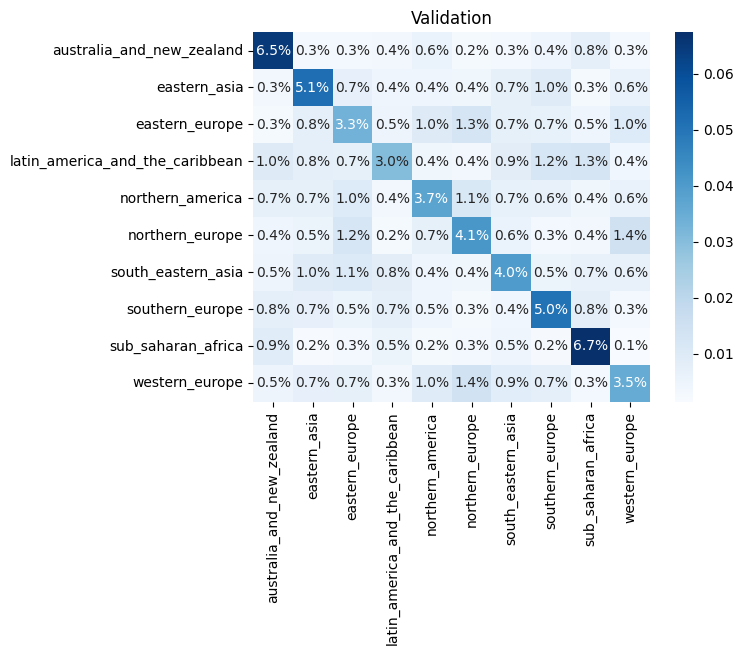

In [162]:
plot_cm(cnn_hgb, cnn_train_X, train_y, "Training")
plot_cm(cnn_hgb, cnn_val_X, val_y, "Validation")

In [163]:
# CNN Pipeline
cnn_pca_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=600)),
    ('clf', HistGradientBoostingClassifier(early_stopping=True))
])

start = time.time()
cnn_pca_hgb.fit(cnn_train_X, train_y)
print(f"Time: {time.time() - start}")
print("Training Accuracy: ",cnn_pca_hgb.score(cnn_train_X, train_y))
print("Validation Accuracy: ",cnn_pca_hgb.score(cnn_val_X, val_y))

Time: 58.32566022872925
Training Accuracy:  0.8235261909107502
Validation Accuracy:  0.40038338658146966


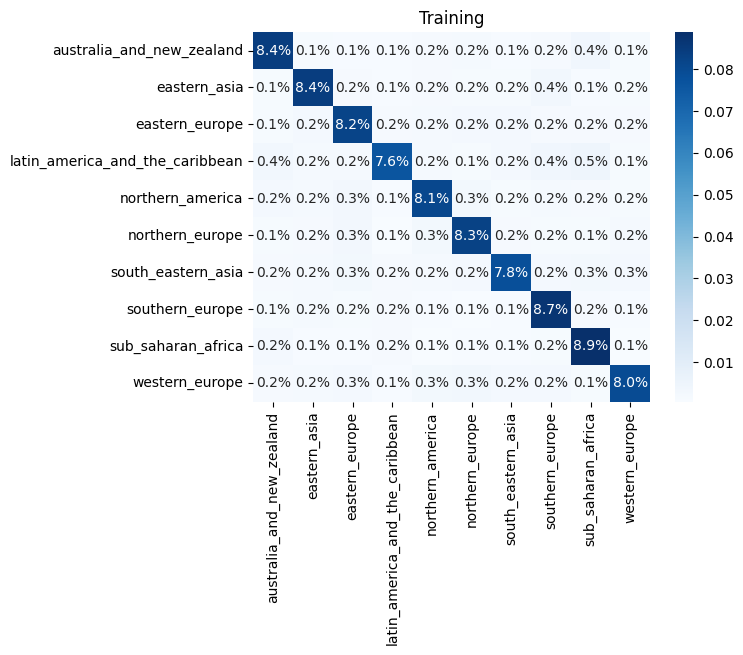

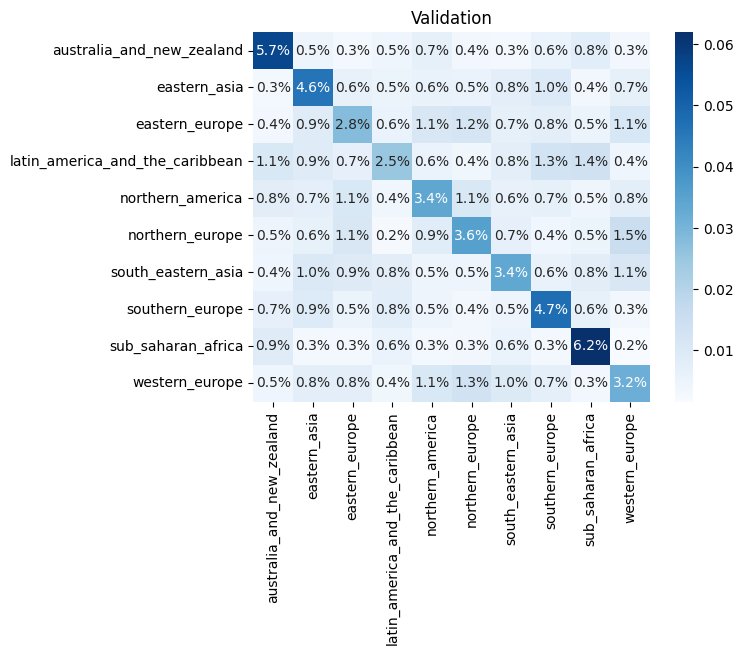

In [164]:
plot_cm(cnn_pca_hgb, cnn_train_X, train_y, "Training")
plot_cm(cnn_pca_hgb, cnn_val_X, val_y, "Validation")

# Grid Search

In [165]:
from sklearn.experimental import enable_halving_search_cv

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer,top_k_accuracy_score,f1_score
f1_scorer = make_scorer(f1_score,average='weighted')

In [202]:
clf_pca_param_grid_hog = {
    'pca__n_components':[5,10,20,30],
    'clf__max_iter':[50, 100, 200, 500],
    'clf__tol':[1,10,100]
    }

clf_pca_param_grid_lbp = {
    'pca__n_components':[5,10,15,18],
    'clf__max_iter':[50, 100, 200, 500],
    'clf__tol':[1,10,100]
    }

clf_pca_param_grid_cnn = {
    'pca__n_components':[100, 300, 500, 700],
    'clf__max_iter':[50, 100, 200, 500],
    'clf__tol':[1,10,100]
    }


clf_param_grid = {
    'clf__max_iter':[50, 100, 200, 500],
    'clf__tol':[1,10,100]
}

In [167]:
# Stacking Train and validation sets together
hog_X = np.vstack([hog_train_X, hog_val_X])
lbp_X = np.vstack([lbp_train_X, lbp_val_X])
cnn_X = np.vstack([cnn_train_X, cnn_val_X])

# clf_y = np.vstack([train_y, val_y])
clf_string_y = np.concatenate((train_y, val_y))

In [168]:
# Convert the english labels into numbers for the grid search
clf_y = np.zeros(clf_string_y.shape)

clf_y[clf_string_y == 'australia_and_new_zealand'] = 0
clf_y[clf_string_y == 'eastern_asia'] = 1
clf_y[clf_string_y == 'eastern_europe'] = 2
clf_y[clf_string_y == 'latin_america_and_the_caribbean'] = 3
clf_y[clf_string_y == 'northern_america'] = 4
clf_y[clf_string_y == 'northern_europe'] = 5
clf_y[clf_string_y == 'south_eastern_asia'] = 6
clf_y[clf_string_y == 'southern_europe'] = 7
clf_y[clf_string_y == 'sub_saharan_africa'] = 8
clf_y[clf_string_y == 'western_europe'] = 9

In [169]:
start = time.time()
hog_lr_grid_search = GridSearchCV(hog_lr, clf_param_grid, cv=5,scoring=f1_scorer,verbose=2)
hog_lr_grid_search.fit(hog_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  19.2s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  17.9s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  18.0s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  18.0s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  15.5s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  13.7s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  10.8s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  10.6s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  12.4s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   6.6s
[CV] END .....................clf__max_iter=50, clf__tol=100; total time=   7.2s
[CV] END .....................clf__max_iter=50, 

In [170]:
hog_lr_best_params = hog_lr_grid_search.best_params_
hog_lr_best_score = hog_lr_grid_search.best_score_
hog_lr_best = hog_lr_grid_search.best_estimator_

print(hog_lr_best_params, '\n',
      hog_lr_best_score, '\n',
      hog_lr_best)

{'clf__max_iter': 50, 'clf__tol': 1} 
 0.17989698513695662 
 Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 LogisticRegression(max_iter=50, solver='newton-cholesky',
                                    tol=1))])


In [203]:
start = time.time()
hog_pca_lr_grid_search = GridSearchCV(hog_pca_lr, clf_pca_param_grid_hog, cv=5,scoring=f1_scorer,verbose=2)
hog_pca_lr_grid_search.fit(hog_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   2.8s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   2.6s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   2.5s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   2.5s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   2.7s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   3.6s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   3.7s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   3.6s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   3.8s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   3.8s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=20; total time=   4.1s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_

In [204]:
hog_pca_lr_best_params = hog_pca_lr_grid_search.best_params_
hog_pca_lr_best_score = hog_pca_lr_grid_search.best_score_
hog_pca_lr_best = hog_pca_lr_grid_search.best_estimator_

print(hog_pca_lr_best_params, '\n',
      hog_pca_lr_best_score, '\n',
      hog_pca_lr_best)

{'clf__max_iter': 50, 'clf__tol': 10, 'pca__n_components': 30} 
 0.12298582628293245 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=30)),
                ('clf',
                 LogisticRegression(max_iter=50, solver='newton-cholesky',
                                    tol=10))])


In [173]:
start = time.time()
hog_hgb_grid_search = GridSearchCV(hog_hgb, clf_param_grid, cv=5,scoring=f1_scorer,verbose=2)
hog_hgb_grid_search.fit(hog_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   3.9s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   3.9s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   3.6s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   4.1s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   4.2s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   3.9s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   4.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   4.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   4.2s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   3.9s
[CV] END .....................clf__max_iter=50, clf__tol=100; total time=   4.1s
[CV] END .....................clf__max_iter=50, 

In [174]:
hog_hgb_best_params = hog_hgb_grid_search.best_params_
hog_hgb_best_score = hog_hgb_grid_search.best_score_
hog_hgb_best = hog_hgb_grid_search.best_estimator_

print(hog_hgb_best_params, '\n',
      hog_hgb_best_score, '\n',
      hog_hgb_best)

{'clf__max_iter': 500, 'clf__tol': 100} 
 0.13613351353044495 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=10)),
                ('clf',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=500, tol=100))])


In [205]:
start = time.time()
hog_pca_hgb_grid_search = GridSearchCV(hog_pca_hgb, clf_pca_param_grid_hog, cv=5,scoring=f1_scorer,verbose=2)
hog_pca_hgb_grid_search.fit(hog_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   2.9s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   3.0s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   3.2s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   3.5s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   3.1s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   4.0s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   4.0s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   4.2s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   5.1s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   4.2s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=20; total time=   4.5s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_

In [206]:
hog_pca_hgb_best_params = hog_pca_hgb_grid_search.best_params_
hog_pca_hgb_best_score = hog_pca_hgb_grid_search.best_score_
hog_pca_hgb_best = hog_pca_hgb_grid_search.best_estimator_

print(hog_pca_hgb_best_params, '\n',
      hog_pca_hgb_best_score, '\n',
      hog_pca_hgb_best)

{'clf__max_iter': 200, 'clf__tol': 100, 'pca__n_components': 30} 
 0.14749579111294583 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=30)),
                ('clf',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=200, tol=100))])


In [177]:
start = time.time()
lbp_lr_grid_search = GridSearchCV(lbp_lr, clf_param_grid, cv=5,scoring=f1_scorer,verbose=2)
lbp_lr_grid_search.fit(lbp_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.1s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.2s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.1s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.1s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.1s
[CV] END .....................clf__max_iter=50, clf__tol=100; total time=   0.2s
[CV] END .....................clf__max_iter=50, 

In [178]:
lbp_lr_best_params = lbp_lr_grid_search.best_params_
lbp_lr_best_score = lbp_lr_grid_search.best_score_
lbp_lr_best = lbp_lr_grid_search.best_estimator_

print(lbp_lr_best_params, '\n',
      lbp_lr_best_score, '\n',
      lbp_lr_best)

{'clf__max_iter': 50, 'clf__tol': 1} 
 0.16419257892409916 
 Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 LogisticRegression(max_iter=50, solver='newton-cholesky',
                                    tol=1))])


In [207]:
start = time.time()
lbp_pca_lr_grid_search = GridSearchCV(lbp_pca_lr, clf_pca_param_grid_lbp, cv=5,scoring=f1_scorer,verbose=2)
lbp_pca_lr_grid_search.fit(lbp_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.2s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.2s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.2s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.2s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.2s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.5s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.6s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.6s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.5s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.7s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=15; total time=   0.5s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_

In [208]:
lbp_pca_lr_best_params = lbp_pca_lr_grid_search.best_params_
lbp_pca_lr_best_score = lbp_pca_lr_grid_search.best_score_
lbp_pca_lr_best = lbp_pca_lr_grid_search.best_estimator_

print(lbp_pca_lr_best_params, '\n',
      lbp_pca_lr_best_score, '\n',
      lbp_pca_lr_best)

{'clf__max_iter': 50, 'clf__tol': 1, 'pca__n_components': 18} 
 0.16129892136735732 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=18)),
                ('clf',
                 LogisticRegression(max_iter=50, solver='newton-cholesky',
                                    tol=1))])


In [181]:
start = time.time()
lbp_hgb_grid_search = GridSearchCV(lbp_hgb, clf_param_grid, cv=5,scoring=f1_scorer,verbose=2)
lbp_hgb_grid_search.fit(lbp_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.5s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.5s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.5s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.5s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   0.5s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.5s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.5s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.5s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.5s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   0.5s
[CV] END .....................clf__max_iter=50, clf__tol=100; total time=   0.6s
[CV] END .....................clf__max_iter=50, 

In [182]:
lbp_hgb_best_params = lbp_hgb_grid_search.best_params_
lbp_hgb_best_score = lbp_hgb_grid_search.best_score_
lbp_hgb_best = lbp_hgb_grid_search.best_estimator_

print(lbp_hgb_best_params, '\n',
      lbp_hgb_best_score, '\n',
      lbp_hgb_best)

{'clf__max_iter': 50, 'clf__tol': 10} 
 0.1907730902775238 
 Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=50, tol=10))])


In [209]:
start = time.time()
lbp_pca_hgb_grid_search = GridSearchCV(lbp_pca_hgb, clf_pca_param_grid_lbp, cv=5,scoring=f1_scorer,verbose=2)
lbp_pca_hgb_grid_search.fit(lbp_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.6s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.6s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.7s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.7s
[CV] END ..clf__max_iter=50, clf__tol=1, pca__n_components=5; total time=   0.7s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   1.0s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.9s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.9s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.9s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=10; total time=   0.9s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_components=15; total time=   1.0s
[CV] END .clf__max_iter=50, clf__tol=1, pca__n_

In [210]:
lbp_pca_hgb_best_params = lbp_pca_hgb_grid_search.best_params_
lbp_pca_hgb_best_score = lbp_pca_hgb_grid_search.best_score_
lbp_pca_hgb_best = lbp_pca_hgb_grid_search.best_estimator_

print(lbp_pca_hgb_best_params, '\n',
      lbp_pca_hgb_best_score, '\n',
      lbp_pca_hgb_best)

{'clf__max_iter': 200, 'clf__tol': 100, 'pca__n_components': 18} 
 0.18501979068465627 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=18)),
                ('clf',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=200, tol=100))])


In [185]:
# Grid search for CNN
start = time.time()
cnn_lr_grid_search = GridSearchCV(cnn_lr, clf_param_grid, cv=5,scoring=f1_scorer,verbose=2)
cnn_lr_grid_search.fit(cnn_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   5.8s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   6.1s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   7.4s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   6.3s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=   6.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   6.4s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   6.0s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   6.4s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   6.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=   6.4s
[CV] END .....................clf__max_iter=50, clf__tol=100; total time=   6.6s
[CV] END .....................clf__max_iter=50, 

In [186]:
cnn_lr_best_params = cnn_lr_grid_search.best_params_
cnn_lr_best_score = cnn_lr_grid_search.best_score_
cnn_lr_best = cnn_lr_grid_search.best_estimator_

print(cnn_lr_best_params, '\n',
      cnn_lr_best_score, '\n',
      cnn_lr_best)

{'clf__max_iter': 50, 'clf__tol': 1} 
 0.4354203165946716 
 Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 LogisticRegression(max_iter=50, solver='newton-cholesky',
                                    tol=1))])


In [211]:
start = time.time()
cnn_pca_lr_grid_search = GridSearchCV(cnn_pca_lr, clf_pca_param_grid_cnn, cv=5,scoring=f1_scorer,verbose=2)
cnn_pca_lr_grid_search.fit(cnn_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   5.4s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   5.7s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   5.8s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   5.9s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   5.6s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=   8.0s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=   7.2s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=   7.3s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=   7.0s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=   8.0s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=500; total time=   9.6s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_c

In [212]:
cnn_pca_lr_best_params = cnn_pca_lr_grid_search.best_params_
cnn_pca_lr_best_score = cnn_pca_lr_grid_search.best_score_
cnn_pca_lr_best = cnn_pca_lr_grid_search.best_estimator_

print(cnn_pca_lr_best_params, '\n',
      cnn_pca_lr_best_score, '\n',
      cnn_pca_lr_best)

{'clf__max_iter': 500, 'clf__tol': 1, 'pca__n_components': 700} 
 0.4191814576738597 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=700)),
                ('clf',
                 LogisticRegression(max_iter=500, solver='newton-cholesky',
                                    tol=1))])


In [189]:
start = time.time()
cnn_hgb_grid_search = GridSearchCV(cnn_hgb, clf_param_grid, cv=5,scoring=f1_scorer,verbose=2)
cnn_hgb_grid_search.fit(cnn_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  18.1s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  18.2s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  18.5s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  17.9s
[CV] END .......................clf__max_iter=50, clf__tol=1; total time=  17.9s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  18.1s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  18.3s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  17.8s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  18.2s
[CV] END ......................clf__max_iter=50, clf__tol=10; total time=  18.1s
[CV] END .....................clf__max_iter=50, clf__tol=100; total time=  17.9s
[CV] END .....................clf__max_iter=50, 

In [190]:
cnn_hgb_best_params = cnn_hgb_grid_search.best_params_
cnn_hgb_best_score = cnn_hgb_grid_search.best_score_
cnn_hgb_best = cnn_hgb_grid_search.best_estimator_

print(cnn_hgb_best_params, '\n',
      cnn_hgb_best_score, '\n',
      cnn_hgb_best)

{'clf__max_iter': 100, 'clf__tol': 1} 
 0.3366046790328868 
 Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 HistGradientBoostingClassifier(early_stopping=True, tol=1))])


In [213]:
start = time.time()
cnn_pca_hgb_grid_search = GridSearchCV(cnn_pca_hgb, clf_pca_param_grid_cnn, cv=5,scoring=f1_scorer,verbose=2)
cnn_pca_hgb_grid_search.fit(cnn_X, clf_y)
print(f"Time: {time.time() - start}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   7.3s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   7.2s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   7.5s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   7.7s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=100; total time=   7.0s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=  11.2s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=  12.1s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=  11.0s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=  11.3s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=300; total time=  11.6s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_components=500; total time=  15.9s
[CV] END clf__max_iter=50, clf__tol=1, pca__n_c

In [214]:
cnn_pca_hgb_best_params = cnn_pca_hgb_grid_search.best_params_
cnn_pca_hgb_best_score = cnn_pca_hgb_grid_search.best_score_
cnn_pca_hgb_best = cnn_pca_hgb_grid_search.best_estimator_

print(cnn_pca_hgb_best_params, '\n',
      cnn_pca_hgb_best_score, '\n',
      cnn_pca_hgb_best)

{'clf__max_iter': 500, 'clf__tol': 100, 'pca__n_components': 100} 
 0.2936819948796139 
 Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=100)),
                ('clf',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=500, tol=100))])


# Final Run on Test Set

In [254]:
# Load Test Data
hog_test_X = np.load(project_path + '/preprocessed_test_no_reduction/X_hog.npy')
lbp_test_X = np.load(project_path + '/preprocessed_test_no_reduction/X_lbp.npy')
cnn_test_X = np.load(project_path + '/preprocessed_test_no_reduction/X_cnn.npy')
test_y = np.load(project_path + '/preprocessed_test_no_reduction/y.npy')

Obtain the best model from above and substitute into the appropriate parameters below.

In [274]:
def create_pipeline(max_iter, tol, lr, pca):
    if lr:
        if pca:
            print('LR PCA')
            return Pipeline([
                        ('scaler', RobustScaler()),
                        ('pca', PCA(n_components=pca)),
                        ('clf', LogisticRegression(solver="newton-cholesky", max_iter=max_iter, tol=tol))
                    ])
        else:
            print('LR')
            return Pipeline([
                        ('scaler', RobustScaler()),
                        ('clf', LogisticRegression(solver="newton-cholesky", max_iter=max_iter, tol=tol))
                    ])
    else:
        if pca:
            print('HGB PCA')
            return Pipeline([
                        ('scaler', RobustScaler()),
                        ('pca', PCA(n_components=pca)),
                        ('clf', HistGradientBoostingClassifier(early_stopping=True, max_iter=max_iter, tol=tol))
                    ])
        else:
            print('HGB')
            return Pipeline([
                        ('scaler', RobustScaler()),
                        ('clf', HistGradientBoostingClassifier(early_stopping=True, max_iter=max_iter, tol=tol))
                    ])

def test_model(max_iter, tol, lr, pca, trainX, valX, testX):
    pipeline = create_pipeline(max_iter, tol, lr, pca)

    pipeline.fit(trainX, train_y)
    start = time.time()
    print("Validation Accuracy: ", pipeline.score(valX, val_y))
    print("Test Accuracy: ", pipeline.score(testX, test_y))
    print(f"Time: {time.time() - start}")

    plot_cm(pipeline, testX, test_y, "Test")

LR
Validation Accuracy:  0.19271565495207668
Test Accuracy:  0.18316326530612245
Time: 0.09158062934875488


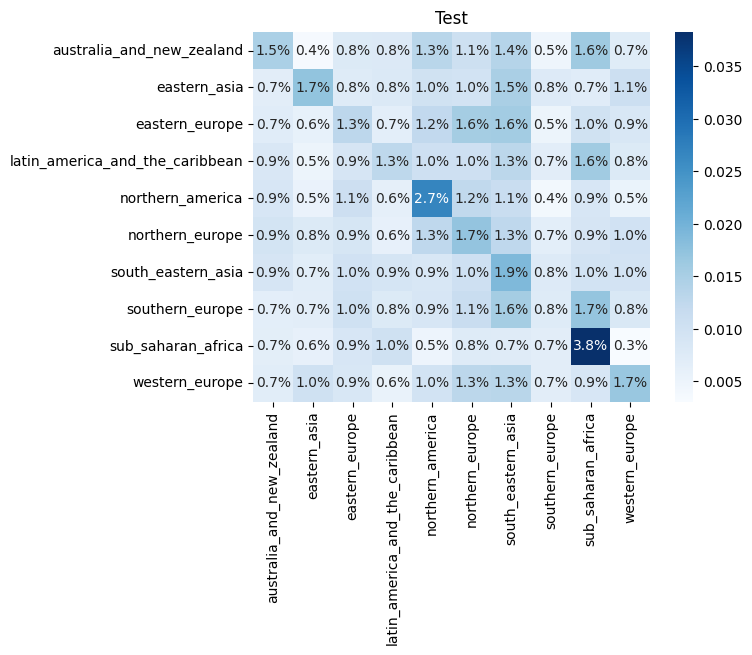

In [275]:
test_model(50, 1e-3, True, False, hog_train_X, hog_val_X, hog_test_X)

LR PCA
Validation Accuracy:  0.15795527156549521
Test Accuracy:  0.1538265306122449
Time: 0.13269472122192383


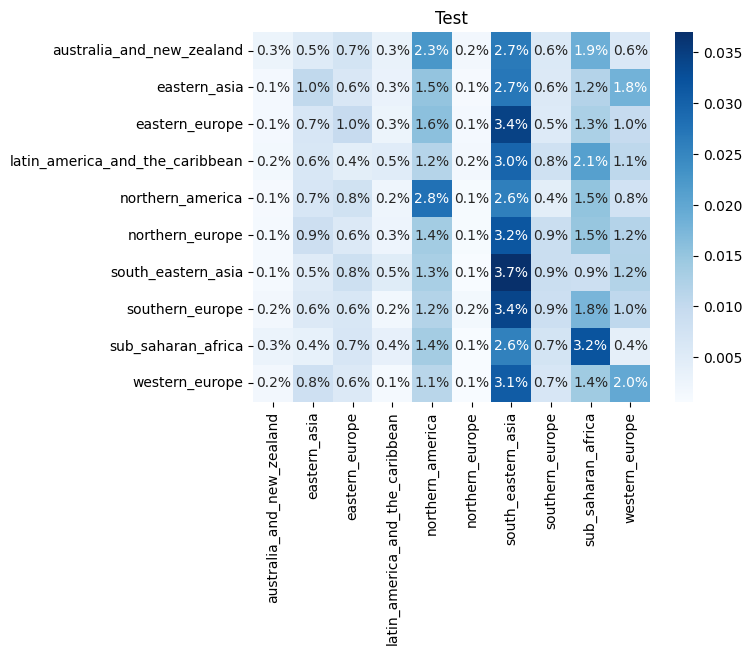

In [276]:
test_model(50, 1e-3, True, 30, hog_train_X, hog_val_X, hog_test_X)

HGB
Validation Accuracy:  0.22408945686900958
Test Accuracy:  0.19693877551020408
Time: 0.9136772155761719


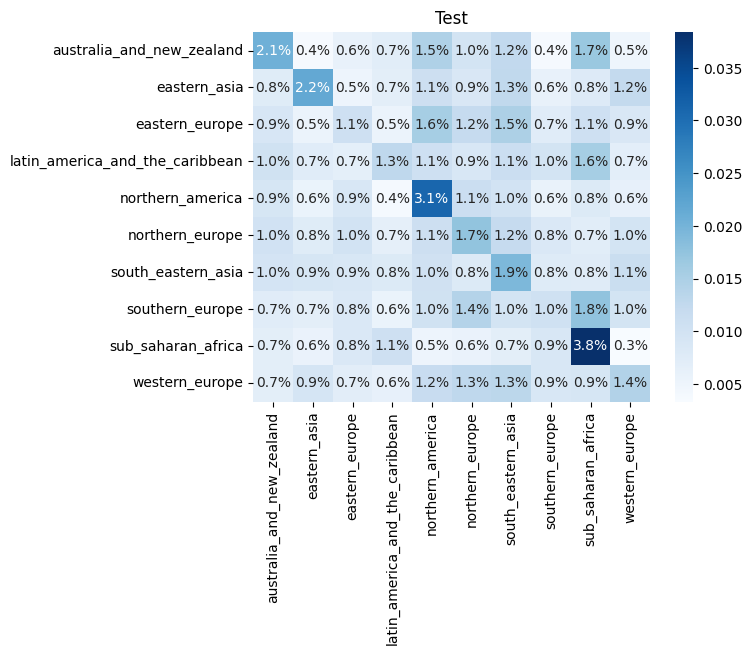

In [277]:
test_model(500, 1e-3, False, False, hog_train_X, hog_val_X, hog_test_X)

HGB PCA
Validation Accuracy:  0.16083067092651757
Test Accuracy:  0.15727040816326532
Time: 0.3272979259490967


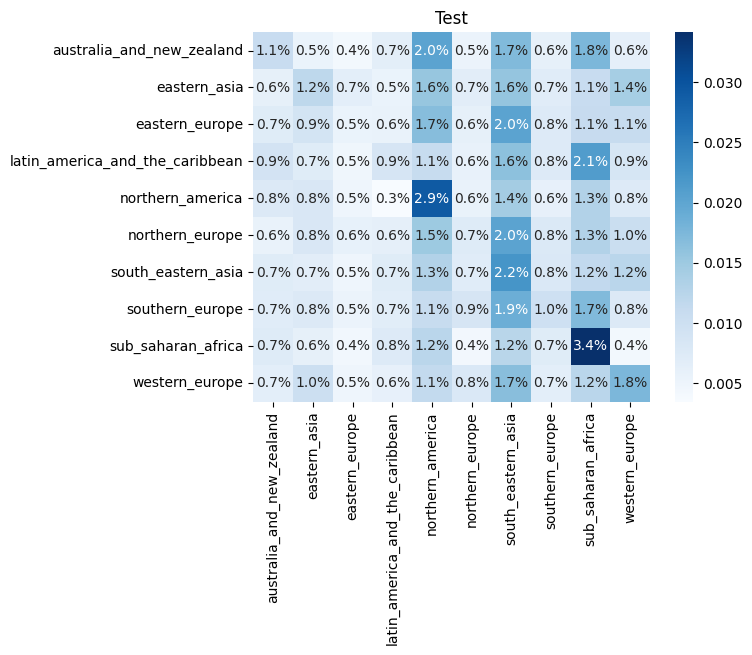

In [278]:
test_model(200, 1e-3, False, 30, hog_train_X, hog_val_X, hog_test_X)

LR
Validation Accuracy:  0.18300319488817893
Test Accuracy:  0.18571428571428572
Time: 0.014492273330688477


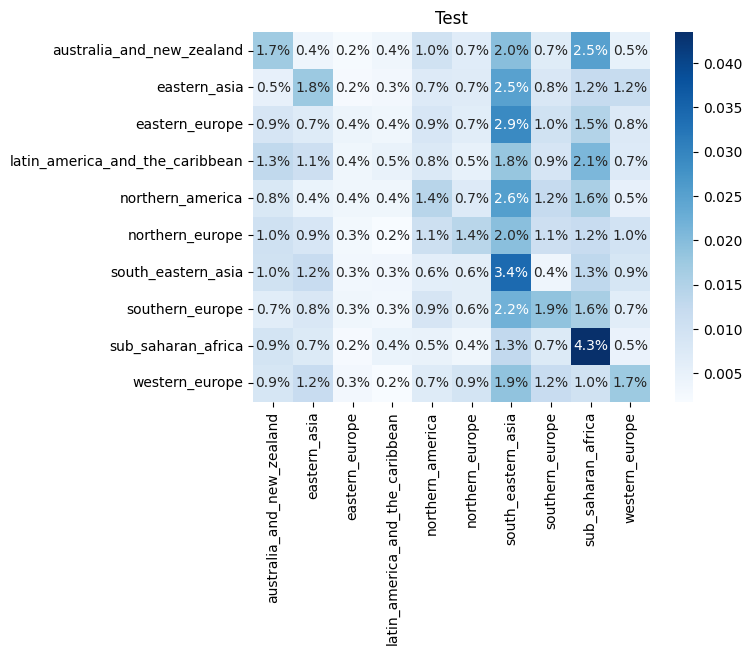

In [279]:
test_model(50, 1e-3, True, False, lbp_train_X, lbp_val_X, lbp_test_X)

LR PCA
Validation Accuracy:  0.18185303514376996
Test Accuracy:  0.18494897959183673
Time: 0.014950752258300781


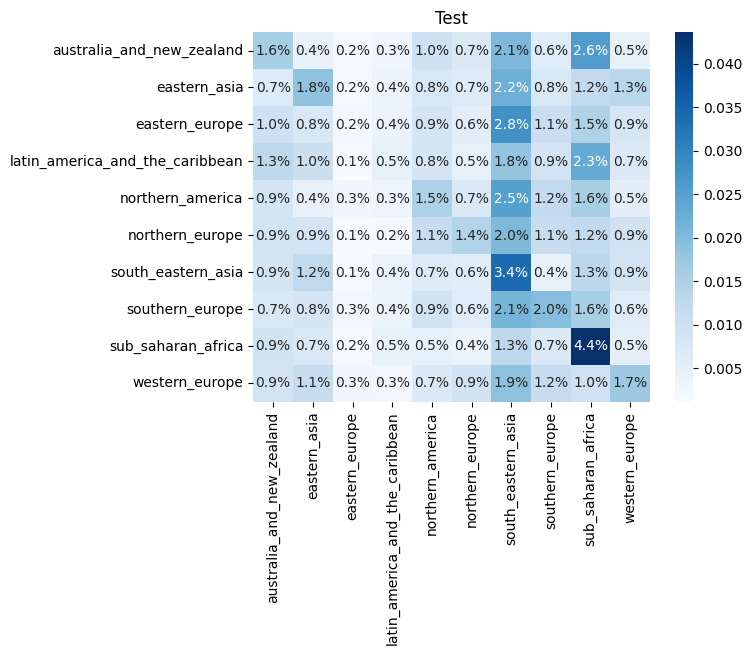

In [280]:
test_model(50, 1e-3, True, 18, lbp_train_X, lbp_val_X, lbp_test_X)

HGB
Validation Accuracy:  0.20453674121405752
Test Accuracy:  0.1868622448979592
Time: 0.1363658905029297


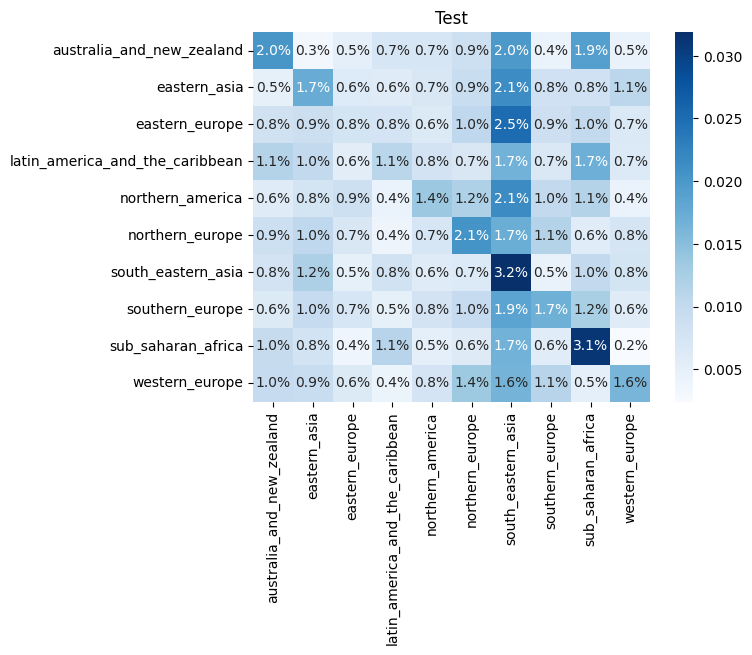

In [281]:
test_model(50, 1e-3, False, False, lbp_train_X, lbp_val_X, lbp_test_X)

HGB PCA
Validation Accuracy:  0.20172523961661343
Test Accuracy:  0.18788265306122448
Time: 0.40335774421691895


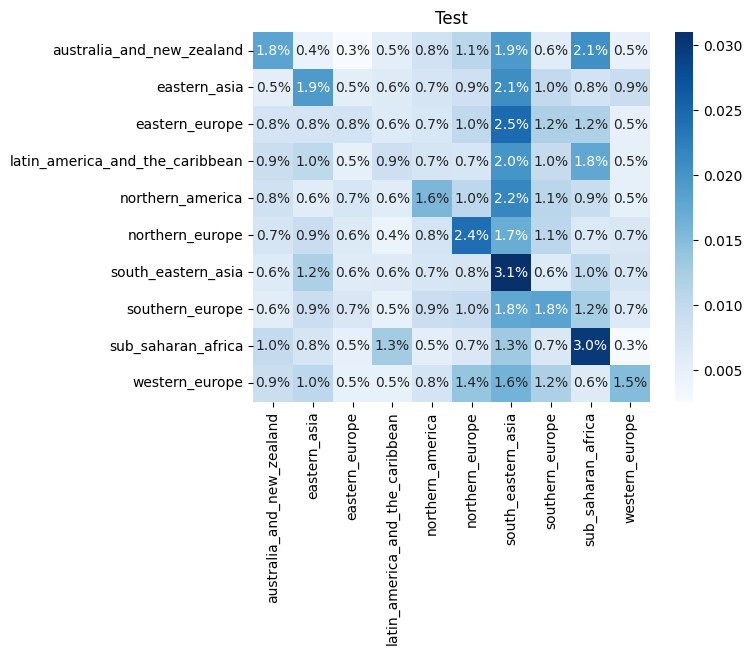

In [282]:
test_model(200, 1e-3, False, 18, lbp_train_X, lbp_val_X, lbp_test_X)

LR
Validation Accuracy:  0.4688817891373802
Test Accuracy:  0.46530612244897956
Time: 0.08039498329162598


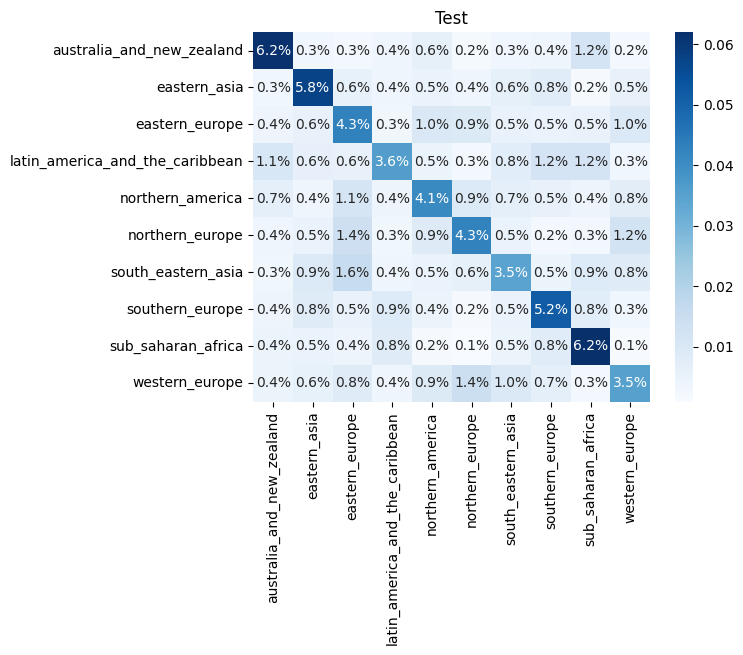

In [283]:
test_model(50, 1e-3, True, False, cnn_train_X, cnn_val_X, cnn_test_X)

LR PCA
Validation Accuracy:  0.4488817891373802
Test Accuracy:  0.44566326530612244
Time: 0.23577404022216797


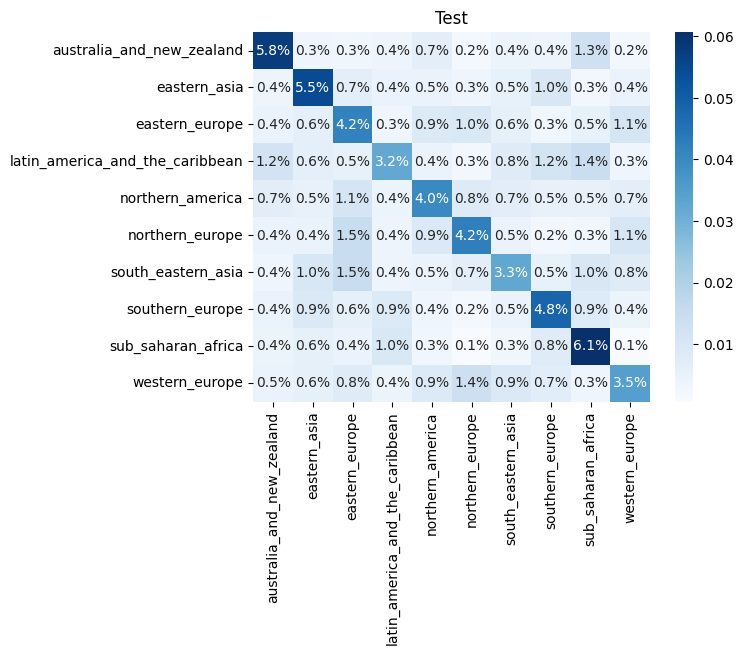

In [284]:
test_model(500, 1e-3, True, 700, cnn_train_X, cnn_val_X, cnn_test_X)

HGB
Validation Accuracy:  0.4462619808306709
Test Accuracy:  0.4603316326530612
Time: 2.457380771636963


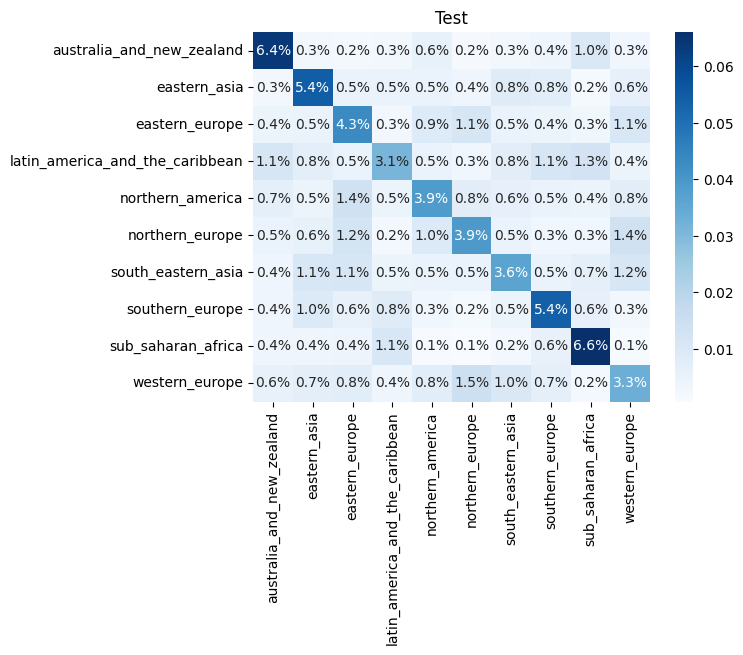

In [285]:
test_model(100, 1e-3, False, False, cnn_train_X, cnn_val_X, cnn_test_X)

HGB PCA
Validation Accuracy:  0.4009584664536741
Test Accuracy:  0.4091836734693878
Time: 0.9107661247253418


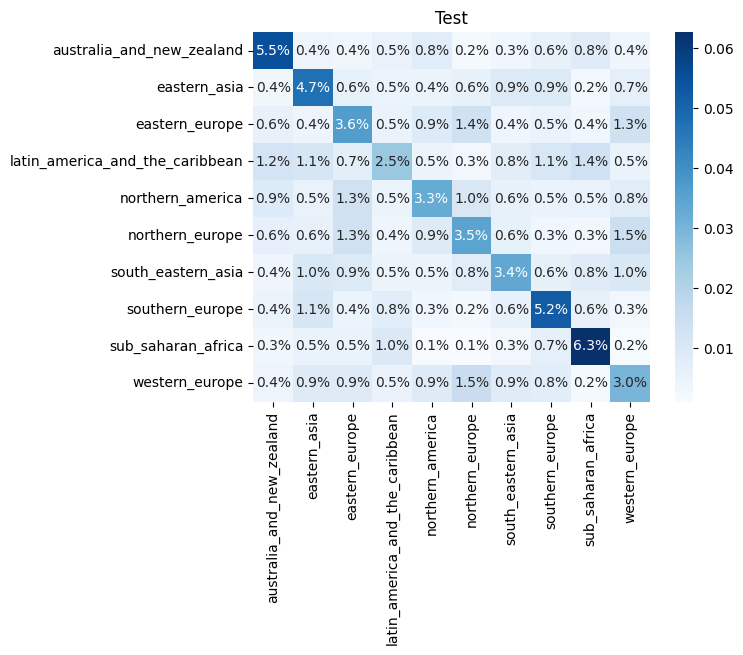

In [286]:
test_model(5000, 1e-3, False, 100, cnn_train_X, cnn_val_X, cnn_test_X)